For running install the necessary packages and include the package folders VeloVAE and NewVeloVAE in the same folder as this notebook

In [1]:
import anndata
import dynamo as dyn
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scvelo as scv
import scanpy as sc
from scipy.sparse import csr_matrix
import seaborn as sns
import SEACells
from sklearn.decomposition import PCA
import sys
import torch
from umap import UMAP

sys.path.append('./NewVeloVAE')
sys.path.append('./VeloVAE')
import newvelovae as nvv
import velovae as vv

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/bernaljp/miniconda3/envs/projectDM/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
%matplotlib inline

In [3]:
n_jobs=48

# Load Input Data
We demonstrate the full training pipeline using an example dataset from scVelo.

In [4]:
dataset = "Zebrafish"
adata = dyn.sample_data.hematopoiesis_raw()

In [5]:
adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    layers: 'spliced', 'unspliced'

Set the parent folder names for saving model parameters, data and figures.

In [6]:
model_path_base = f"checkpoints/Checkpoint2/{dataset}"
figure_path_base = f"figures/Checkpoint2/{dataset}"
data_path_base = f"data/Checkpoint2/{dataset}"

<br><br><br><br><br>
# Preprocessing
We apply exactly the same preprocessing steps as scVelo.
The "preprocess" function performs the following:
1. Cell and gene filtering based on mRNA counts.<br><br>
2. Select a number of genes. By default, it applies the selection method in scVelo to pick highly variable genes. The user can also choose to pick a balanced set of genes by setting <b>"selection_method"</b> to "balanced", meaning that all cell types have the same number of marker genes. Besides these two options, the user can also input a custom list of genes via the argument <b>"genes_retain"</b>.<br><br>
3. Compute a KNN graph based on PCA and average the count data across k neighbors. Dimension of PCA can be set via the argument <b>"npc"</b>. The user can also set the number of neighbors via <b>"n_neighbors"</b>.<br><br>
4. Optionally performs clustering when <b>"perform_clustering"</b> is set to "True".<br><br>
5. Optionally add informative time prior if <b>"tkey"</b> is set to the key in .obs that contains the capture time (either string or float).<br><br>
5. Optionally computes 2D UMAP embedding when <b>"compute_umap"</b> is set to "True".

Pick some genes to plot.

# Find the Metacells with SEAcells

In [7]:
adata.obsm['X_umap'] = adata.obs[['umap_1','umap_2']].values

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


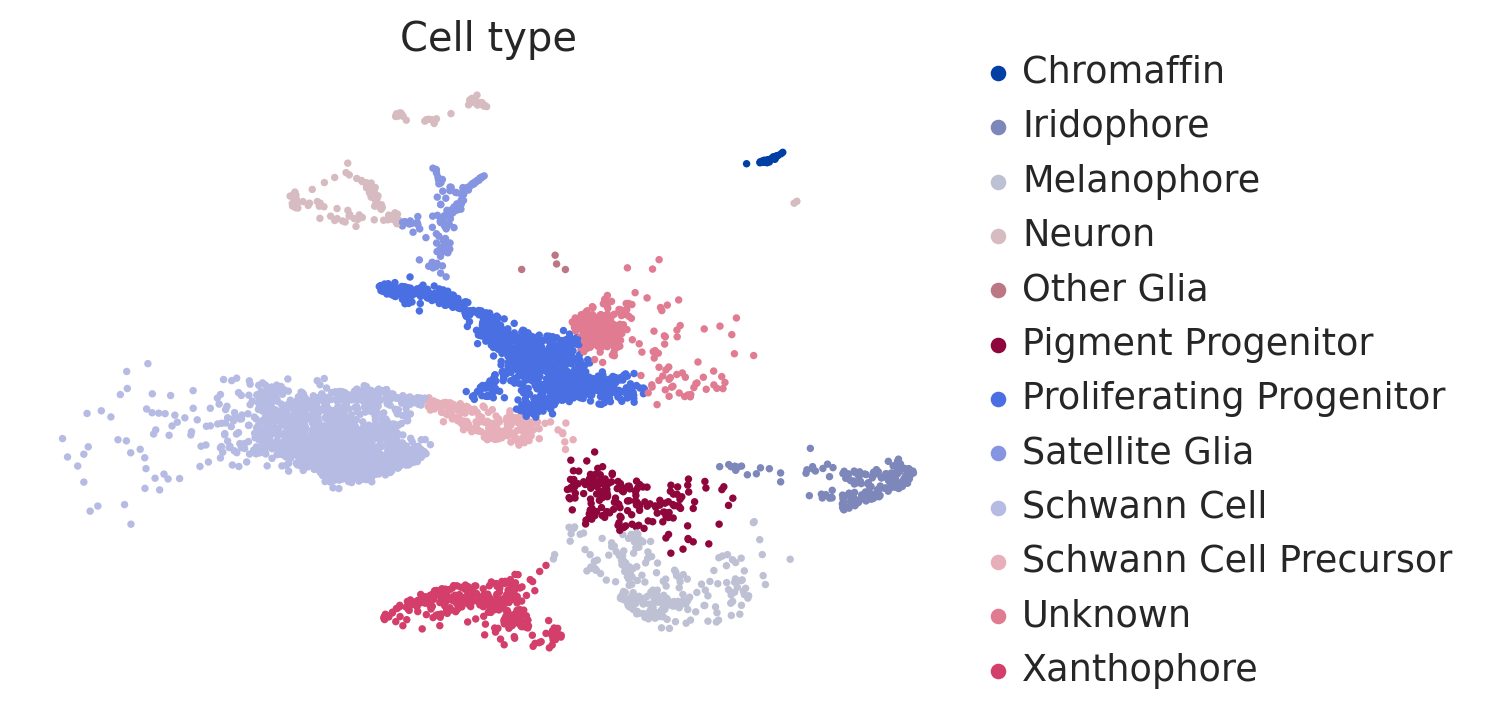

In [9]:
scv.pl.scatter(adata,basis='umap',color='Cell_type',legend_loc='right margin')

In [7]:
## User defined parameters

## Core parameters 
n_SEACells = 90
build_kernel_on = 'X_umap' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [8]:
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells,
                  #use_gpu = True, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [9]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Computing radius for adaptive bandwidth kernel...


  0%|          | 0/4181 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/4181 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/4181 [00:00<?, ?it/s]

Constructing CSR matrix...


In [ ]:
# Initialize archetypes
model.initialize_archetypes()

In [ ]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00122
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 29 iterations.


In [ ]:
vv.preprocess(adata, 3000, method='sklearn')

Filtered out 12103 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 3000 highly variable genes.
Logarithmized X.
Computing the KNN graph based on X_pca
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Keep raw unspliced/spliced count data.


In [ ]:
adata.obs_names_make_unique()

In [ ]:
SEACell_ad = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='Ms')
SEACell_ad.layers['Ms'] = SEACell_ad.layers['raw']
SEACell_ad.layers['Mu'] = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='Mu').layers['raw']
SEACell_ad.layers['spliced'] = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='spliced').layers['raw']
SEACell_ad.layers['unspliced'] = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='unspliced').layers['raw']

SEACell_ad.layers['Ms'] = SEACell_ad.layers['Ms'].A
SEACell_ad.layers['Mu'] = SEACell_ad.layers['Mu'].A
SEACell_ad.layers['spliced'] = SEACell_ad.layers['spliced'].A
SEACell_ad.layers['unspliced'] = SEACell_ad.layers['unspliced'].A

del SEACell_ad.layers['raw']
SEACell_ad

100%|██████████| 90/90 [00:00<00:00, 450.55it/s]


AnnData object with n_obs × n_vars = 90 × 3000
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


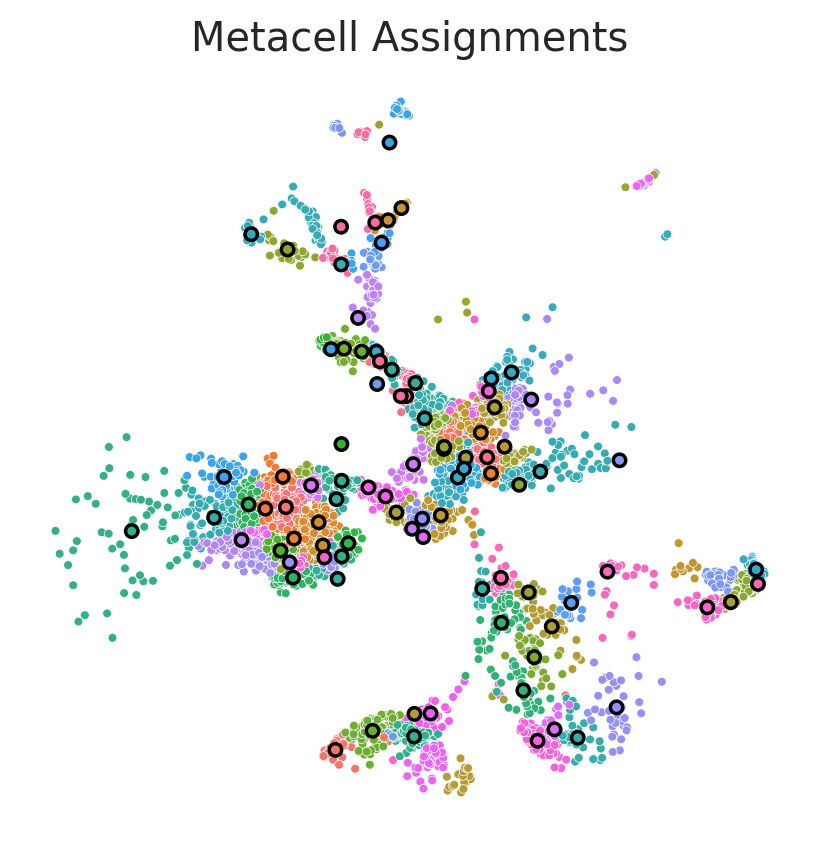

In [ ]:
SEACells.plot.plot_2D(adata, key='X_umap', colour_metacells=True)

# Run scVelo
Overview of the dataset on UMAP

In [ ]:
adata.obs['Cell_type']

index
TGCCAAATCACCACCT-1-0                Schwann Cell
AAATGCCAGGAGCGTT-1-0                     Unknown
CAGCGACAGAGAACAG-1-0                Schwann Cell
GGGACCTGTGACCAAG-1-0                     Unknown
TCCCGATAGTGTGGCA-1-0                Schwann Cell
                                  ...           
TAGACCAAGTCCATAC-1-1                  Chromaffin
GGTGTTAAGGAATCGC-1-1                 Xanthophore
CTACCCAAGTGACATA-1-1    Proliferating Progenitor
TACTCATGTTACGCGC-1-1    Proliferating Progenitor
TCAACGACACTCTGTC-1-1                      Neuron
Name: Cell_type, Length: 4181, dtype: category
Categories (12, object): ['Chromaffin', 'Iridophore', 'Melanophore', 'Neuron', ..., 'Schwann Cell', 'Schwann Cell Precursor', 'Unknown', 'Xanthophore']

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


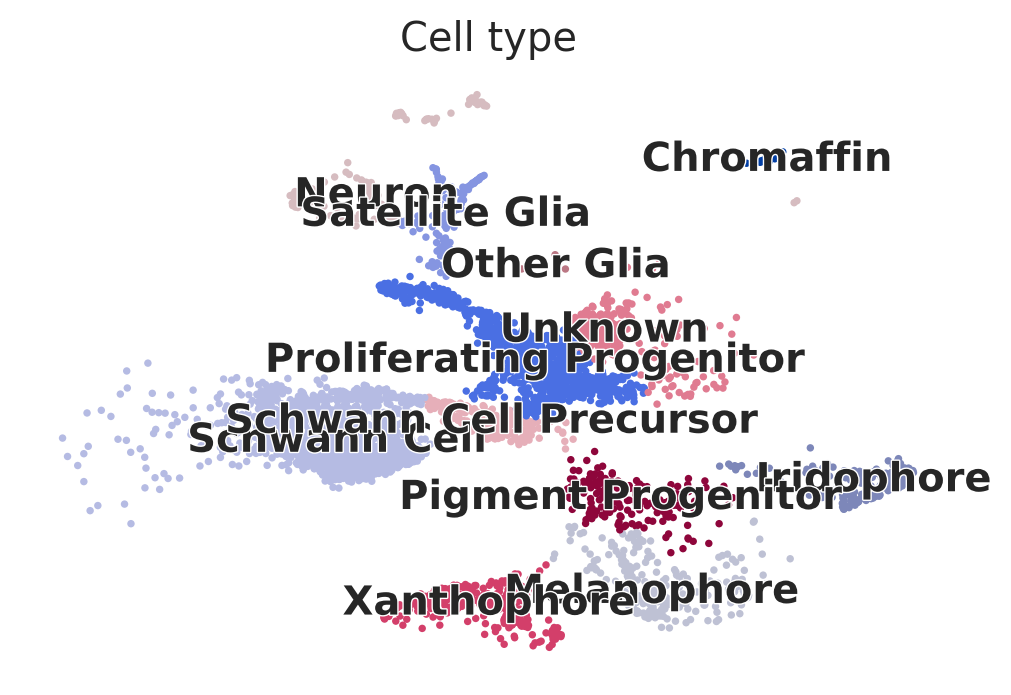

In [ ]:
os.makedirs(figure_path_base, exist_ok=True)
scv.pl.scatter(adata, basis='umap',color='Cell_type')#, save=figure_path_base+"/umap.png")

Run scVelo and compute the velocity and latent time

In [ ]:
scv.tl.recover_dynamics(adata,n_jobs=n_jobs)
scv.tl.velocity(adata, vkey='velocity', mode='dynamical',n_jobs=n_jobs)
scv.tl.latent_time(adata)

recovering dynamics (using 48/48 cores)


  0%|          | 0/792 [00:00<?, ?gene/s]

    finished (0:01:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


<br><br><br><br><br>
# Train a Full VeloVAE Model
***
## Step 1: Define saving paths
We store the figures in "figure_path", model parameters in "model_path" and updated .h5ad file in data_path.

In [ ]:
figure_path_dependent = figure_path_base+"/DependentFullVAE"
model_path_dependent = model_path_base+"/DependentFullVAE"
figure_path = figure_path_base+"/FullVAE"
model_path = model_path_base+"/FullVAE"
data_path = data_path_base

## Step 2: Create a VAE object
Mandatory Arguments:
1. <b>adata</b>: anndata object<br><br>
2. <b>tmax</b>: time range. We set it to 20 following the convention from scVelo.<br><br>

Critical Arguments:
1. <b>device</b>: please set to the corresponding cuda device for training if possible.<br><br>
2. <b>hidden_size</b>: a tuple, e.g. (500,250). The two numbers are width of the first and second hidden layers of the encoder network.<br><br>
3. <b>init_method</b>: rate parameter initialization method. By default, the parameter is set to "steady", meaning the steady state model. However, if capture time is available, please consider setting it to "tprior", and the model will be initialized from a time series where the time is approximated by the capture time.<br><br>
4. <b>init_key</b>: key in .obs storing the informative time prior. This is effective only if init_method is set to "tprior".<br><br>
5. <b>tprior</b>: key in .obs storing the informative time prior. <b>This is usually the same key as "init_key", but has a different purpose. This key is used when we compute the KL divergence in ELBO, while "init_key" is used only in initialization.</b>

In [ ]:
torch.manual_seed(2022)
np.random.seed(2022)

# mvae = mvv.VAE(adata, SEACell_ad, tmax=20, dim_z=5, device='cuda:0')
full_vae = vv.VAE(adata, tmax=20, dim_z=5, device='cuda:0', full_vb=True)
full_dvae = nvv.VAE(adata, tmax=20, dim_z1=10, dim_z=5, device='cuda:0', full_vb=True)

Estimating ODE parameters...


  0%|          | 0/3000 [00:00<?, ?it/s]

Detected 606 velocity genes.
Estimating the variance...


  0%|          | 0/3000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/3000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.61, 0.7947046537241705), (0.39, 0.4209536892816291)
(0.70, 0.8373339796998522), (0.30, 0.4202973592096242)
KS-test result: [0. 0. 1.]
Initial induction: 2240, repression: 760/3000
Estimating ODE parameters...


  0%|          | 0/3000 [00:00<?, ?it/s]

Detected 606 velocity genes.
Estimating the variance...


  0%|          | 0/3000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/3000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.62, 0.7924309942794435), (0.38, 0.41935026657051055)
(0.70, 0.83426104538768), (0.30, 0.40987383616149436)
KS-test result: [0. 0. 1.]
Initial induction: 2234, repression: 766/3000


## Step 3: Mini-batch training
Mandatory Arguments:
1. <b>adata</b>: anndata object
***
Critical Arguments:
1. <b>config</b>: a dictionary containing all hyperparameters. The keys are parameter names (string). Most default hyperparameters achieved consistent performance across different datasets. However, we recommend modifying the following hyperparameters in certain situations:<br><br>
(1) <b>batch_size</b>: set to 128 by default. However, for large datasets, we recommend increasing the batch size accordingly.<br><br>
(2) <b>early_stop</b>: set to 5 by default. This is the number of consecutive epochs when the validation loss decreases by less than some threshold (introduced in the next item), used in early stopping. <br><br>
(3) <b>early_stop_thred</b>: set to $n_{gene}\cdot 10^{-3}$ by default. This is the threshold used in early stopping.<br>

"config" will not be required if you just want the default, as shown in the following line of code.

### Train MetaVeloVAE
Extra mandatory Arguments:
1. <b>meta_adata</b>: anndata object for the metacells

In [ ]:
full_dvae.train(adata, SEACell_ad, plot=True, figure_path=figure_path_dependent)

Learning Rate based on Data Sparsity: 0.0003
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 23, test iteration: 44
Epoch 1: Train ELBO = -25250.992,	Test ELBO = -407551.578,	Total Time =   0 h :  0 m :  1 s
Epoch 100: Train ELBO = 565.398,	Test ELBO = 628.208,	Total Time =   0 h :  1 m :  2 s
Epoch 200: Train ELBO = 1982.973,	Test ELBO = 2075.086,	Total Time =   0 h :  2 m :  3 s
Epoch 300: Train ELBO = 3291.956,	Test ELBO = 3354.578,	Total Time =   0 h :  3 m :  4 s
Epoch 400: Train ELBO = 3925.272,

  0%|          | 0/4181 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.028
Average Set Size: 84
Epoch 761: Train ELBO = 6512.205,	Test ELBO = 6835.801,	Total Time =   0 h :  7 m : 54 s
Epoch 800: Train ELBO = 6820.463,	Test ELBO = 7118.571,	Total Time =   0 h :  8 m : 19 s
Epoch 900: Train ELBO = 7093.741,	Test ELBO = 7318.968,	Total Time =   0 h :  9 m : 21 s
*********     Round 1: Early Stop Triggered at epoch 933.    *********
Change in noise variance: 0.2801
*********             Velocity Refinement Round 2             *********
Epoch 934: Train ELBO = 7350.130,	Test ELBO = 7494.436,	Total Time =   0 h :  9 m : 44 s
*********     Round 2: Early Stop Triggered at epoch 949.    *********
Change in noise variance: 0.0045
Change in x0: 0.2280
*********             Velocity Refinement Round 3             *********
Epoch 950: Train ELBO = 7239.163,	Test ELBO = 7370.371,	Total Time =   0 h :  9 m : 56 s
*********     Round 3: Early Stop Triggered at epoch 957.    *********
Change in noise variance: 0.0005
Change in x0: 0.2019
**

### Train VeloVAE

In [ ]:
full_vae.train(adata, plot=True, figure_path=figure_path)

Learning Rate based on Data Sparsity: 0.0003
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 23, test iteration: 44
Epoch 1: Train ELBO = -4654.077,	Test ELBO = -86709.961,	Total Time =   0 h :  0 m :  1 s
Epoch 100: Train ELBO = 4735.662,	Test ELBO = 4684.378,	Total Time =   0 h :  0 m : 47 s
Epoch 200: Train ELBO = 4959.900,	Test ELBO = 4898.280,	Total Time =   0 h :  1 m : 32 s
*********       Stage 1: Early Stop Triggered at epoch 213.       *********
*********                      Stage  2       

  0%|          | 0/4181 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.023
Average Set Size: 84
Epoch 214: Train ELBO = 5339.400,	Test ELBO = 3802.929,	Total Time =   0 h :  1 m : 43 s
Epoch 300: Train ELBO = 7694.879,	Test ELBO = 7547.402,	Total Time =   0 h :  2 m : 25 s
Epoch 400: Train ELBO = 7922.666,	Test ELBO = 7590.629,	Total Time =   0 h :  3 m : 13 s
Epoch 500: Train ELBO = 8072.620,	Test ELBO = 7693.087,	Total Time =   0 h :  4 m :  2 s
Epoch 600: Train ELBO = 8162.162,	Test ELBO = 7825.110,	Total Time =   0 h :  4 m : 50 s
Epoch 700: Train ELBO = 8223.766,	Test ELBO = 7893.374,	Total Time =   0 h :  5 m : 38 s
Change in noise variance: 0.2870
*********             Velocity Refinement Round 2             *********
Epoch 714: Train ELBO = 8190.529,	Test ELBO = 7883.516,	Total Time =   0 h :  5 m : 47 s
Epoch 800: Train ELBO = 8253.401,	Test ELBO = 7942.250,	Total Time =   0 h :  6 m : 28 s
*********     Round 2: Early Stop Triggered at epoch 887.    *********
Change in noise variance: 0.0019
Change in x0: 0.2119
***

## Step 4: Save results

In [ ]:
full_vae.save_model(model_path, "encoder","decoder")
full_vae.save_anndata(adata, 'full_vae', data_path, file_name="zebrafish_out.h5ad")

# mvae.save_model(model_path_meta, "encoder_meta","decoder_meta")
# mvae.save_anndata(adata, SEACell_ad, 'meta_vae', data_path, file_name="zebrafish_out.h5ad")

full_dvae.save_model(model_path_dependent, "encoder_dependent_full","decoder_dependent_full")
full_dvae.save_anndata(adata, SEACell_ad, 'dependent_full_vae', data_path, file_name="zebrafish_out.h5ad")

<br><br><br><br><br>
# Post Analysis
## Compute the Metrics and Plot the Genes
Use the built-in analysis function of the velovae package
***
Mandatory Arguments:
1. <b>adata</b>: anndata object<br><br>
2. <b>test_id</b>: name of the test. Used for storing the figures.<br><br>
3. <b>methods</b>: name of the methods. Should be a list containing one or multiple of the following: "scVelo", "Vanilla VAE", "VeloVAE", "Full VB".<br><br>
4. <b>keys</b>: list of key names corresponding to each method. This is used to extract all relevant quantities (latent variables, rate parameters). For example, when we pick VeloVAE as the method, the corresponding key is "vae". The rate parameters were previously stored as "vae_alpha", "vae_beta", "vae_gamma" in .var when we called the 'save_anndata' function. 
***
Critical Arguments:
1. <b>compute_metrics</b>: whether to compute the performance metrics. Should be set to False if you only want figures.<br><br>
2. <b>genes</b>: genes to plot.<br><br>
3. <b>plot_type</b>: list of plot type names. Should contain zero or more from the following: "phase", "signal", "time", "cluster".<br><br>
4. <b>grid_size</b>: tuple, e.g. (M,N). The signal plot of genes will be in a single figure containing a grid of subplots. The grid has M rows and N columns. If $M\times N<n_{gene}$, multiple figures will be generated.

In [ ]:
vv.scvelo_preprocessing.moments(adata,method='sklearn',n_pcs=30)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Cluster scores

In [ ]:
methods = ['VeloVAE','VeloVAE']
keys = ['full_vae','dependent_full_vae']
grid_size = (1,2)
plot_type = ["phase","signal","time"]
vv.post_analysis(adata, 
                 test_id="pancreas",
                 methods=methods, 
                 keys=keys,
                 compute_metrics=True,
                 plot_type=plot_type, 
                 embed="umap", 
                 grid_size=grid_size, 
                 save_path=figure_path_base,
                 cluster_key='Cell_type',
                 n_jobs=n_jobs)

['rab41' 'tjp1a']
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:27) --> added 
    'vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:15) --> added 
    'vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'dependent_vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:15) --> added 
    'dependent_vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'dependent_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:17) --> added 
    'dependent_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:18) --> added 
    'full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'dependent_full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:17) --> added 
    'dependent_full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 4181 cells, 3000 genes
---   Plotting  Results   ---


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


In [ ]:
results_df[0].dropna()

Vanilla VAE  Vanilla VAE (dependent_vanilla)  \
MSE Train                            0.498                            0.484   
MSE Test                             0.494                            0.467   
MAE Train                            0.275                            0.262   
MAE Test                             0.278                            0.261   
LL Train                            61.928                          129.651   
LL Test                             74.204                          138.419   
Training Time                      137.623                          275.891   
In-Cluster Coherence (Subset)        0.980                            0.960   
Vel Consistency (Subset)             0.975                            0.920   
In-Cluster Coherence                 0.984                            0.973   
Vel Consistency                      0.985                            0.973   

                                VeloVAE  VeloVAE (dependent_vae)  \
MSE Train                         0.067                    1.172   
MSE Test                          0.075                    1.148   
MAE Train                         0.122                    0.318   
MAE Test                          0.127                    0.312   
LL Train                       1666.960                  726.770   
LL Test                        1614.883                  753.763   
Training Time                   532.839                  228.108   
In-Cluster Coherence (Subset)     0.709                    0.921   
Vel Consistency (Subset)          0.658                    0.898   
In-Cluster Coherence              0.752                    0.935   
Vel Consistency                   0.696                    0.918   

                               VeloVAE (full_vae)  \
MSE Train                                   0.217   
MSE Test                                    0.227   
MAE Train                                   0.173   
MAE Test                                    0.178   
LL Train                                 1473.136   
LL Test                                  1404.154   
Training Time                             709.772   
In-Cluster Coherence (Subset)               0.854   
Vel Consistency (Subset)                    0.866   
In-Cluster Coherence                        0.832   
Vel Consistency                             0.833   

                               VeloVAE (dependent_full_vae)  
MSE Train                                             0.527  
MSE Test                                              0.467  
MAE Train                                             0.245  
MAE Test                                              0.237  
LL Train                                           1022.742  
LL Test                                            1059.517  
Training Time                                       716.110  
In-Cluster Coherence (Subset)                         0.934  
Vel Consistency (Subset)                              0.947  
In-Cluster Coherence                                  0.945  
Vel Consistency                                       0.963

### Cluster edges

In [ ]:
cluster_edges = [('Proliferating Progenitor','Schwann Cell Precursor'),
                 ('Proliferating Progenitor','Pigment Progenitor'),
                 ('Proliferating Progenitor','Satellite Glia'),
                 ('Schwann Cell Precursor','Schwann Cell'),
                 ('Schwann Cell Precursor','Chromaffin'),
                 ('Satellite Glia','Neuron'),
                 ('Satellite Glia','Other Glia'),
                 ('Pigment Progenitor','Melanophore'),
                 ('Pigment Progenitor','Iridophore'),
                 ('Pigment Progenitor','Xanthophore')]

In [ ]:
methods = ['VeloVAE','VeloVAE']
keys = ['full_vae','dependent_full_vae']
grid_size = (1,2)
plot_type = ["phase","signal","time"]
st,stt = vv.post_analysis(adata, 
                 test_id="pancreas",
                 methods=methods, 
                 keys=keys,
                 compute_metrics=True,
                 plot_type=plot_type, 
                 embed="umap", 
                 grid_size=grid_size, 
                 figure_path=figure_path_base,
                 cluster_key='Cell_type',
                 cluster_edges=cluster_edges,
                 n_jobs=n_jobs)

['hmgb2a' 'ofd1']
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:29) --> added 
    'vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:15) --> added 
    'vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'dependent_vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'dependent_vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'dependent_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:17) --> added 
    'dependent_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'dependent_full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'dependent_full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dependent_full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 4181 cells, 3000 genes
---   Plotting  Results   ---
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction because of key value error or invalid data type.
[** Warning **]: Skip plotting the prediction becau

In [ ]:
st.dropna()

Vanilla VAE  Vanilla VAE (dependent_vanilla)  \
MSE Train                            0.498                            0.484   
MSE Test                             0.494                            0.467   
MAE Train                            0.275                            0.262   
MAE Test                             0.278                            0.261   
LL Train                            61.928                          129.651   
LL Test                             74.204                          138.419   
Training Time                      137.623                          275.891   
CBDir (Embed, Subset)                0.157                            0.222   
CBDir (Subset)                       0.174                            0.191   
In-Cluster Coherence (Subset)        0.980                            0.960   
Vel Consistency (Subset)             0.975                            0.920   
CBDir (Embed)                        0.216                            0.272   
CBDir                                0.101                            0.135   
Time Score                           0.521                            0.530   
In-Cluster Coherence                 0.984                            0.973   
Vel Consistency                      0.985                            0.973   

                                VeloVAE  VeloVAE (dependent_vae)  \
MSE Train                         0.067                    1.172   
MSE Test                          0.075                    1.148   
MAE Train                         0.122                    0.318   
MAE Test                          0.127                    0.312   
LL Train                       1666.960                  726.770   
LL Test                        1614.883                  753.763   
Training Time                   532.839                  228.108   
CBDir (Embed, Subset)             0.272                    0.136   
CBDir (Subset)                    0.122                    0.028   
In-Cluster Coherence (Subset)     0.709                    0.921   
Vel Consistency (Subset)          0.658                    0.898   
CBDir (Embed)                     0.184                    0.260   
CBDir                             0.134                    0.111   
Time Score                        0.521                    0.475   
In-Cluster Coherence              0.752                    0.935   
Vel Consistency                   0.696                    0.918   

                               VeloVAE (full_vae)  \
MSE Train                                   0.217   
MSE Test                                    0.227   
MAE Train                                   0.173   
MAE Test                                    0.178   
LL Train                                 1473.136   
LL Test                                  1404.154   
Training Time                             709.772   
CBDir (Embed, Subset)                       0.166   
CBDir (Subset)                              0.170   
In-Cluster Coherence (Subset)               0.854   
Vel Consistency (Subset)                    0.866   
CBDir (Embed)                               0.155   
CBDir                                       0.172   
Time Score                                  0.411   
In-Cluster Coherence                        0.832   
Vel Consistency                             0.833   

                               VeloVAE (dependent_full_vae)  
MSE Train                                             0.527  
MSE Test                                              0.467  
MAE Train                                             0.245  
MAE Test                                              0.237  
LL Train                                           1022.742  
LL Test                                            1059.517  
Training Time                                       716.110  
CBDir (Embed, Subset)                                 0.226  
CBDir (Subset)                                        0.197  
In-Clust

In [ ]:
print('Full VAE')
stt['VeloVAE'].iloc[:,:8]

VAE


(Proliferating Progenitor, Schwann Cell Precursor)  \
CBDir (Subset)                                                     0.242    
CBDir (Embed, Subset)                                              0.543    
CBDir                                                              0.035    
CBDir (Embed)                                                      0.227    
Time Score                                                         0.228    

                       (Proliferating Progenitor, Pigment Progenitor)  \
CBDir (Subset)                                                  0.121   
CBDir (Embed, Subset)                                           0.129   
CBDir                                                           0.159   
CBDir (Embed)                                                   0.025   
Time Score                                                      0.511   

                       (Proliferating Progenitor, Satellite Glia)  \
CBDir (Subset)                                             -0.067   
CBDir (Embed, Subset)                                       0.046   
CBDir                                                      -0.055   
CBDir (Embed)                                              -0.043   
Time Score                                                  0.569   

                       (Schwann Cell Precursor, Schwann Cell)  \
CBDir (Subset)                                          0.353   
CBDir (Embed, Subset)                                   0.342   
CBDir                                                   0.310   
CBDir (Embed)                                           0.344   
Time Score                                              0.332   

                       (Satellite Glia, Neuron)  \
CBDir (Subset)                            0.062   
CBDir (Embed, Subset)                     0.268   
CBDir                                     0.013   
CBDir (Embed)                             0.033   
Time Score                                0.503   

                       (Pigment Progenitor, Melanophore)  \
CBDir (Subset)                                     0.033   
CBDir (Embed, Subset)                              0.171   
CBDir                                              0.086   
CBDir (Embed)                                      0.269   
Time Score                                         0.490   

                       (Pigment Progenitor, Iridophore)  \
CBDir (Subset)                                    0.035   
CBDir (Embed, Subset)                             0.027   
CBDir                                             0.116   
CBDir (Embed)                                     0.053   
Time Score                                        0.620   

                       (Pigment Progenitor, Xanthophore)  
CBDir (Subset)                                     0.198  
CBDir (Embed, Subset)                              0.648  
CBDir                                              0.411  
CBDir (Embed)                                      0.566  
Time Score                                         0.917

In [ ]:
print('Full Dependent VAE')
stt['VeloVAE'].iloc[:,8:16]

Dependent VAE


(Proliferating Progenitor, Schwann Cell Precursor)  \
CBDir (Subset)                                                    -0.043    
CBDir (Embed, Subset)                                             -0.233    
CBDir                                                             -0.040    
CBDir (Embed)                                                      0.238    
Time Score                                                         0.774    

                       (Proliferating Progenitor, Pigment Progenitor)  \
CBDir (Subset)                                                  0.022   
CBDir (Embed, Subset)                                           0.269   
CBDir                                                           0.087   
CBDir (Embed)                                                   0.243   
Time Score                                                      0.250   

                       (Proliferating Progenitor, Satellite Glia)  \
CBDir (Subset)                                             -0.013   
CBDir (Embed, Subset)                                       0.094   
CBDir                                                       0.142   
CBDir (Embed)                                               0.127   
Time Score                                                  0.155   

                       (Schwann Cell Precursor, Schwann Cell)  \
CBDir (Subset)                                         -0.052   
CBDir (Embed, Subset)                                  -0.306   
CBDir                                                   0.038   
CBDir (Embed)                                           0.159   
Time Score                                              0.850   

                       (Satellite Glia, Neuron)  \
CBDir (Subset)                           -0.024   
CBDir (Embed, Subset)                     0.369   
CBDir                                     0.006   
CBDir (Embed)                             0.461   
Time Score                                0.780   

                       (Pigment Progenitor, Melanophore)  \
CBDir (Subset)                                     0.101   
CBDir (Embed, Subset)                              0.164   
CBDir                                              0.057   
CBDir (Embed)                                      0.132   
Time Score                                         0.529   

                       (Pigment Progenitor, Iridophore)  \
CBDir (Subset)                                    0.032   
CBDir (Embed, Subset)                             0.032   
CBDir                                             0.020   
CBDir (Embed)                                     0.050   
Time Score                                        0.293   

                       (Pigment Progenitor, Xanthophore)  
CBDir (Subset)                                     0.201  
CBDir (Embed, Subset)                              0.704  
CBDir                                              0.575  
CBDir (Embed)                                      0.669  
Time Score                                         0.167

## Cell Time and State Uncertainty
We can call plot_state_var and plot_time_var directly from the velovae.plotting module.

In [ ]:
basis = "umap"

## Plotting satate variables

### VAE original

In [ ]:
key = 'full_vae'
std_z = adata.obsm[f"{key}_std_z"]
z = adata.obsm[f"{key}_z"]
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Checkpoint2/Zebrafish/zebrafish_full_vae_state_var.png")

### Dependent VAE

In [ ]:
key = 'dependent_vae'
std_z = adata.obsm[f"{key}_std_z"]
z = adata.obsm[f"{key}_z"]
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Checkpoint2/Zebrafish/zebrafish_dependent_vae_state_var.png")

std_z = adata.obsm[f"{key}_std_z1"]
z = adata.obsm[f"{key}_z1"]
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Checkpoint2/Zebrafish/zebrafish_dependent_vae_state_var1.png")

In [ ]:
key = 'dependent_full_vae'
std_z = adata.obsm[f"{key}_std_z"]
z = adata.obsm[f"{key}_z"]
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Checkpoint2/Zebrafish/zebrafish_dependent_full_vae_state_var.png")

std_z = adata.obsm[f"{key}_std_z1"]
z = adata.obsm[f"{key}_z1"]
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Checkpoint2/Zebrafish/zebrafish_dependent_full_vae_state_var1.png")

### Time

In [ ]:
t = adata.obs["full_vae_time"].to_numpy()
std_t = adata.obs["full_vae_std_t"].to_numpy()
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_time_var(std_t, X_embed, t, save=f"figures/Checkpoint2/Zebrafish/zebrafish_full_vae_time_var.png")

t = adata.obs["dependent_full_vae_time"].to_numpy()
std_t = adata.obs["dependent_full_vae_std_t"].to_numpy()
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_time_var(std_t, X_embed, t, save=f"figures/Checkpoint2/Zebrafish/zebrafish_dependent_full_vae_time_var.png")

## Other Results
The following plots are not part of the package and we show them here as supplementary results.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

key = "full_vae"
t3 = adata.obs[f'{key}_time'].to_numpy()
rho3 = adata.layers[f'{key}_rho']

key = "dependent_full_vae"
t4 = adata.obs[f'{key}_time'].to_numpy()
rho4 = adata.layers[f'{key}_rho']

cell_labels = adata.obs['Cell_type'].to_numpy()
cell_types = np.unique(cell_labels)
colors = vv.plotting.get_colors(len(cell_types))

## Result 1: Transcription Rate $\rho$

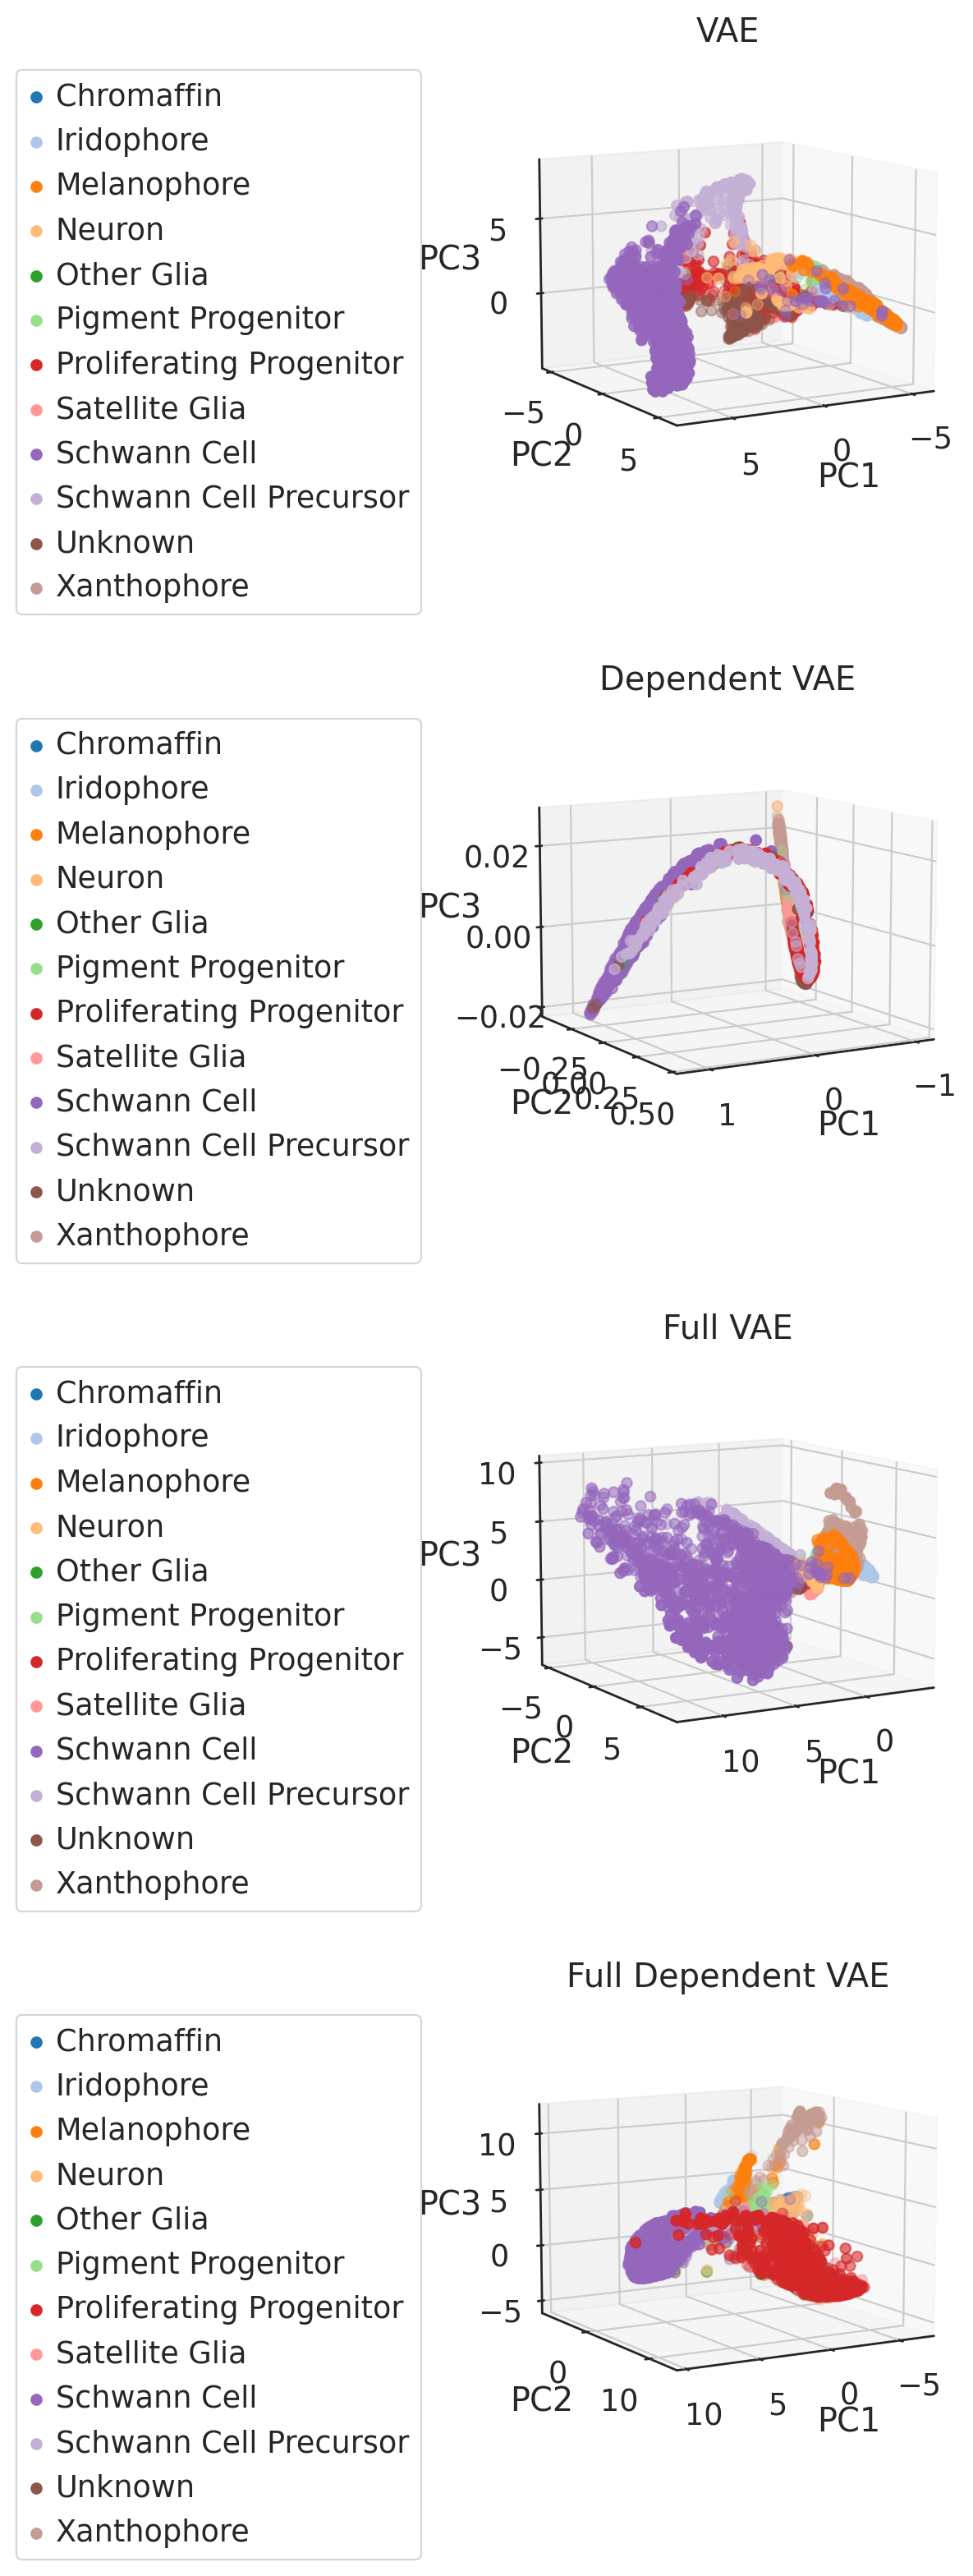

In [ ]:
pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho1)

fig=plt.figure(figsize=(10,16))

ax = fig.add_subplot(4,1,1,projection='3d')
ax.view_init(10, 60)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('VAE')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')

pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho2)

ax = fig.add_subplot(4,1,2,projection='3d')
ax.view_init(10, 60)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Dependent VAE')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')

pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho3)
ax = fig.add_subplot(4,1,3,projection='3d')
ax.view_init(10, 60)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Full VAE')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')

pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho4)

ax = fig.add_subplot(4,1,4,projection='3d')
ax.view_init(10, 60)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Full Dependent VAE')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')

plt.tight_layout()
plt.show()

fig.savefig(figure_path_base+'/rho_pca.png')

## Result 2: Latent Embedding

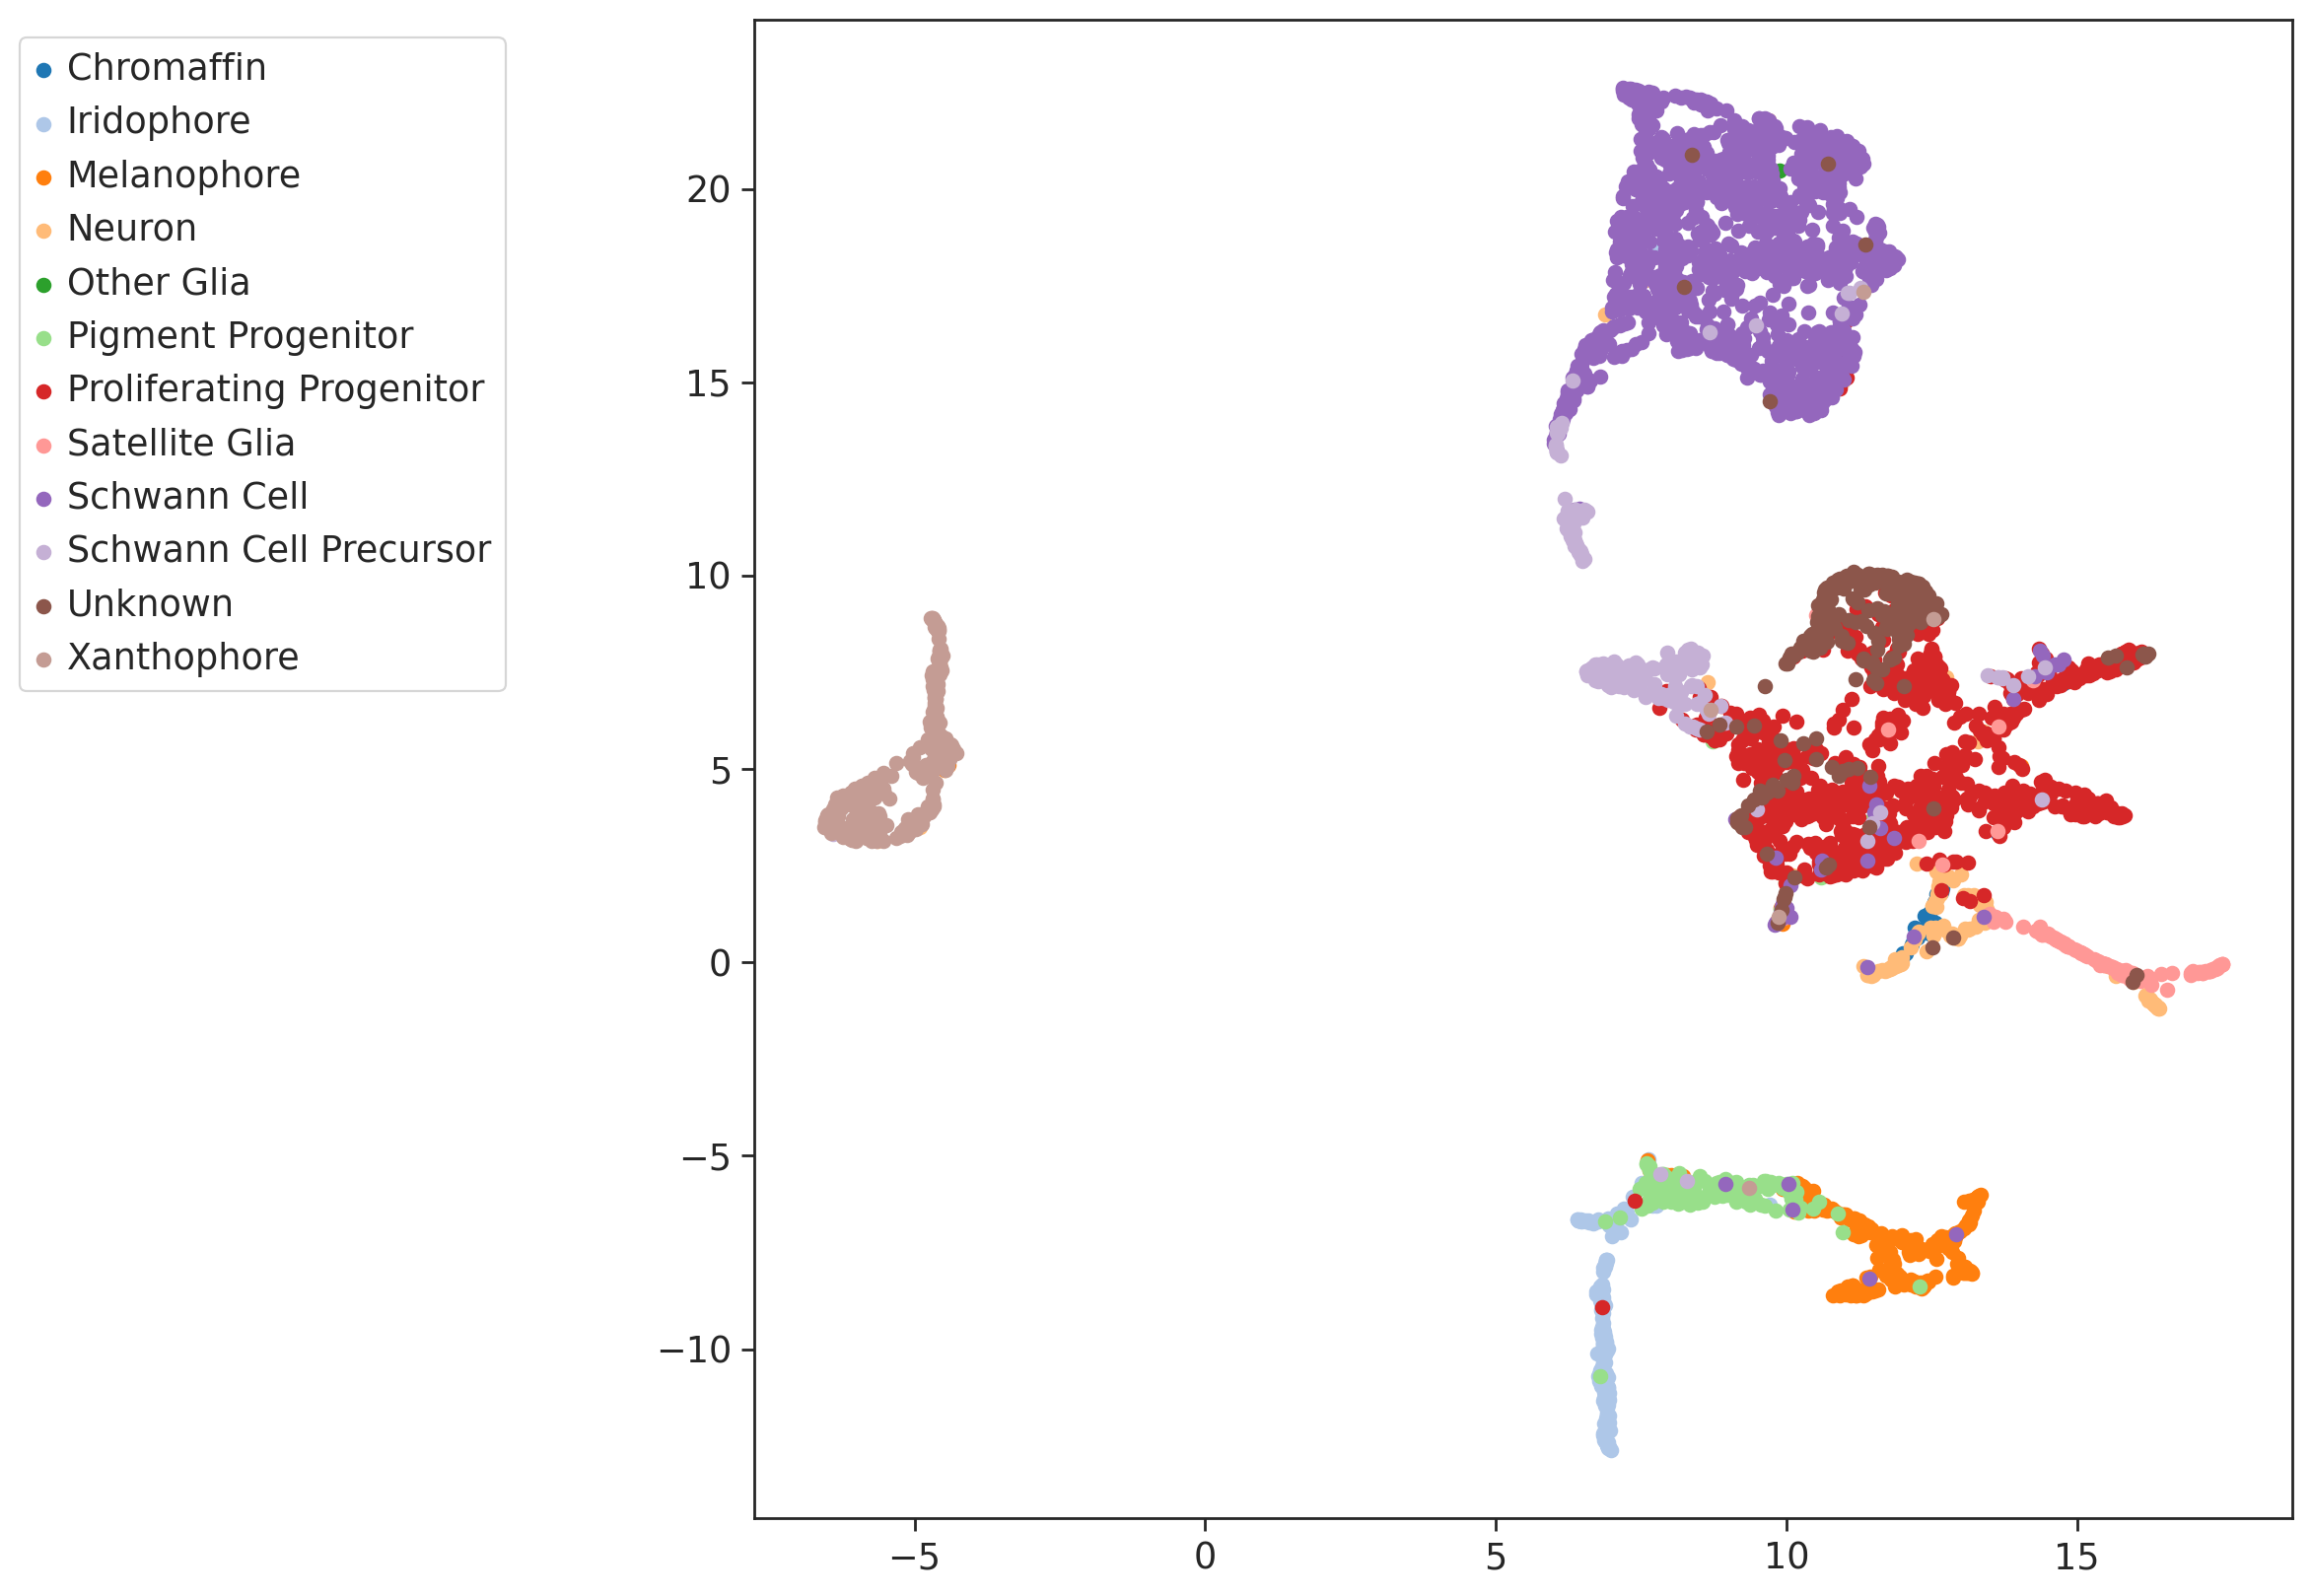

In [ ]:
import umap

key = 'full_vae'
z = adata.obsm[f"{key}_z"]
umap_obj = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.25)
z_umap = umap_obj.fit_transform(z)

fig=plt.figure(figsize=(10,10))
for i,x in enumerate((cell_types)):
    plt.scatter(z_umap[cell_labels==x,0], z_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.show()
fig.savefig(figure_path_base+'/full_vae_z_umap.png')

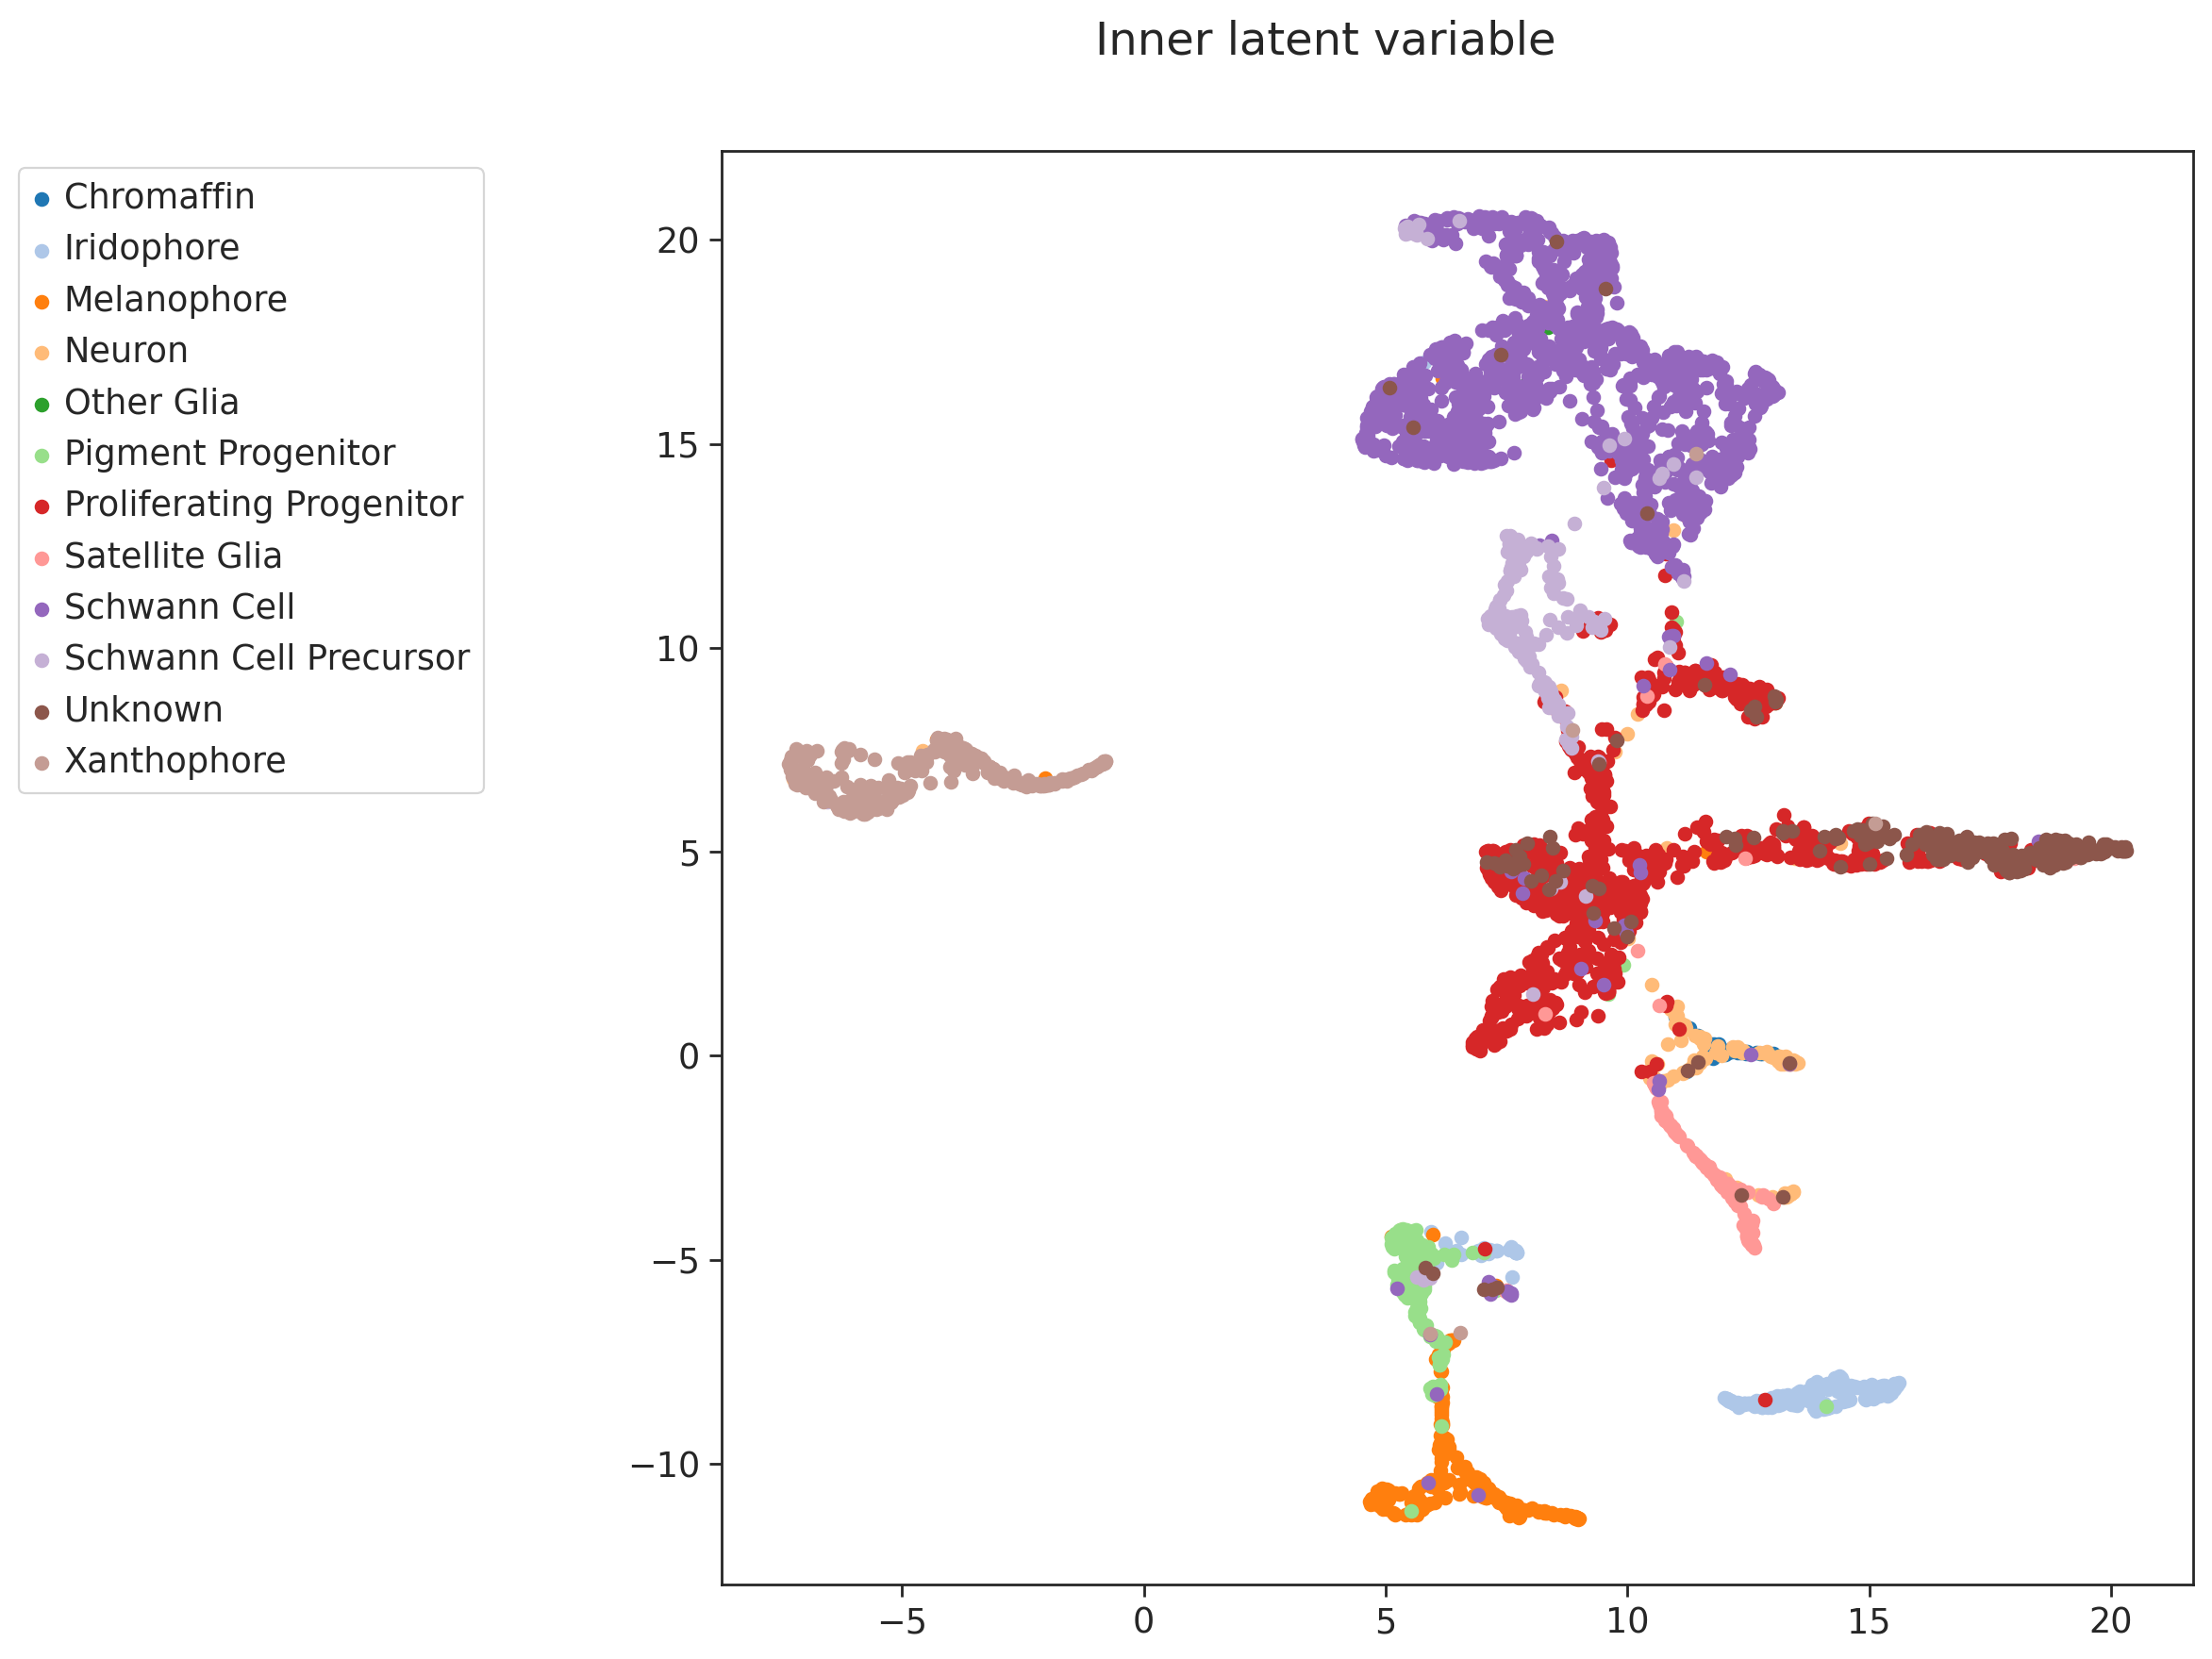

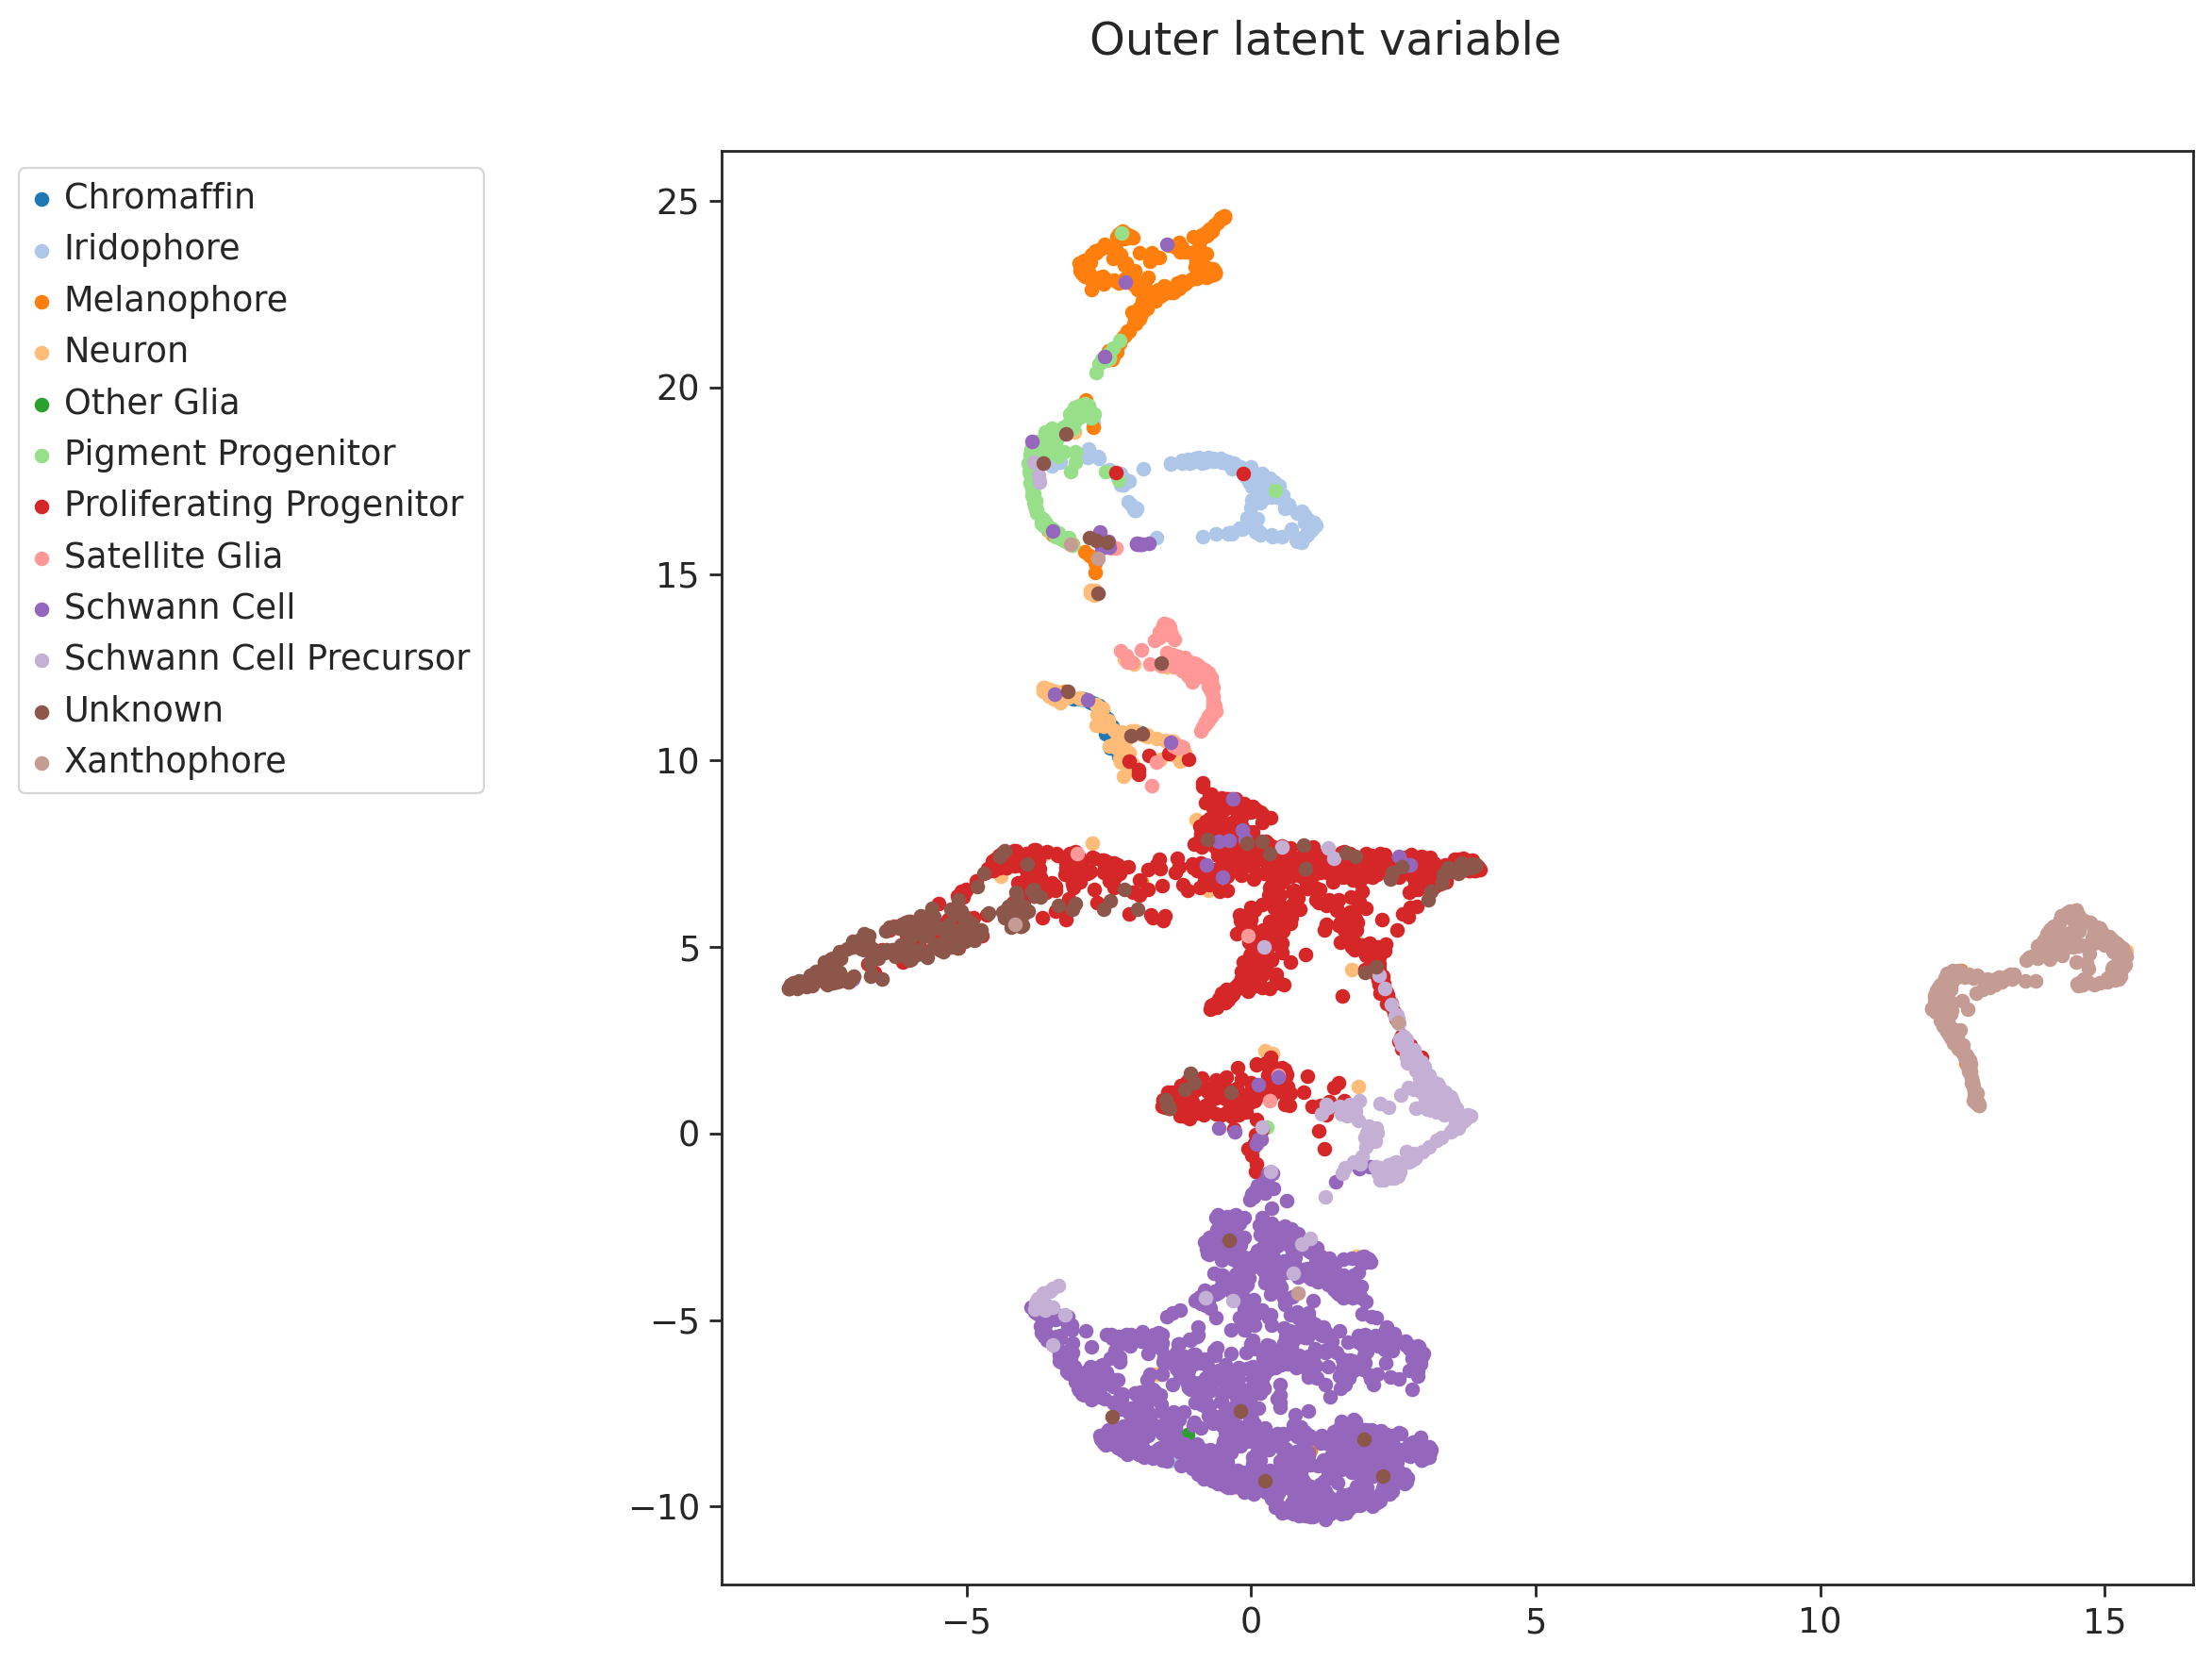

In [ ]:
key = 'dependent_full_vae'

z = adata.obsm[f"{key}_z"]
umap_obj = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.25)
z_umap = umap_obj.fit_transform(z)

fig=plt.figure(figsize=(10,10))
fig.suptitle("Inner latent variable")
for i,x in enumerate((cell_types)):
    plt.scatter(z_umap[cell_labels==x,0], z_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.show()
fig.savefig(figure_path_base+'/dependent_full_vae_z_umap.png')

z = adata.obsm[f"{key}_z1"]
umap_obj = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.25)
z_umap = umap_obj.fit_transform(z)

fig=plt.figure(figsize=(10,10))
fig.suptitle("Outer latent variable")
for i,x in enumerate((cell_types)):
    plt.scatter(z_umap[cell_labels==x,0], z_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')

plt.show()
fig.savefig(figure_path_base+'/dependent_full_vae_z1_umap.png')

## Result 3: Velocity Stream Plot

computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Checkpoint2/Zebrafish/Zebrafish_velocity_scv.png


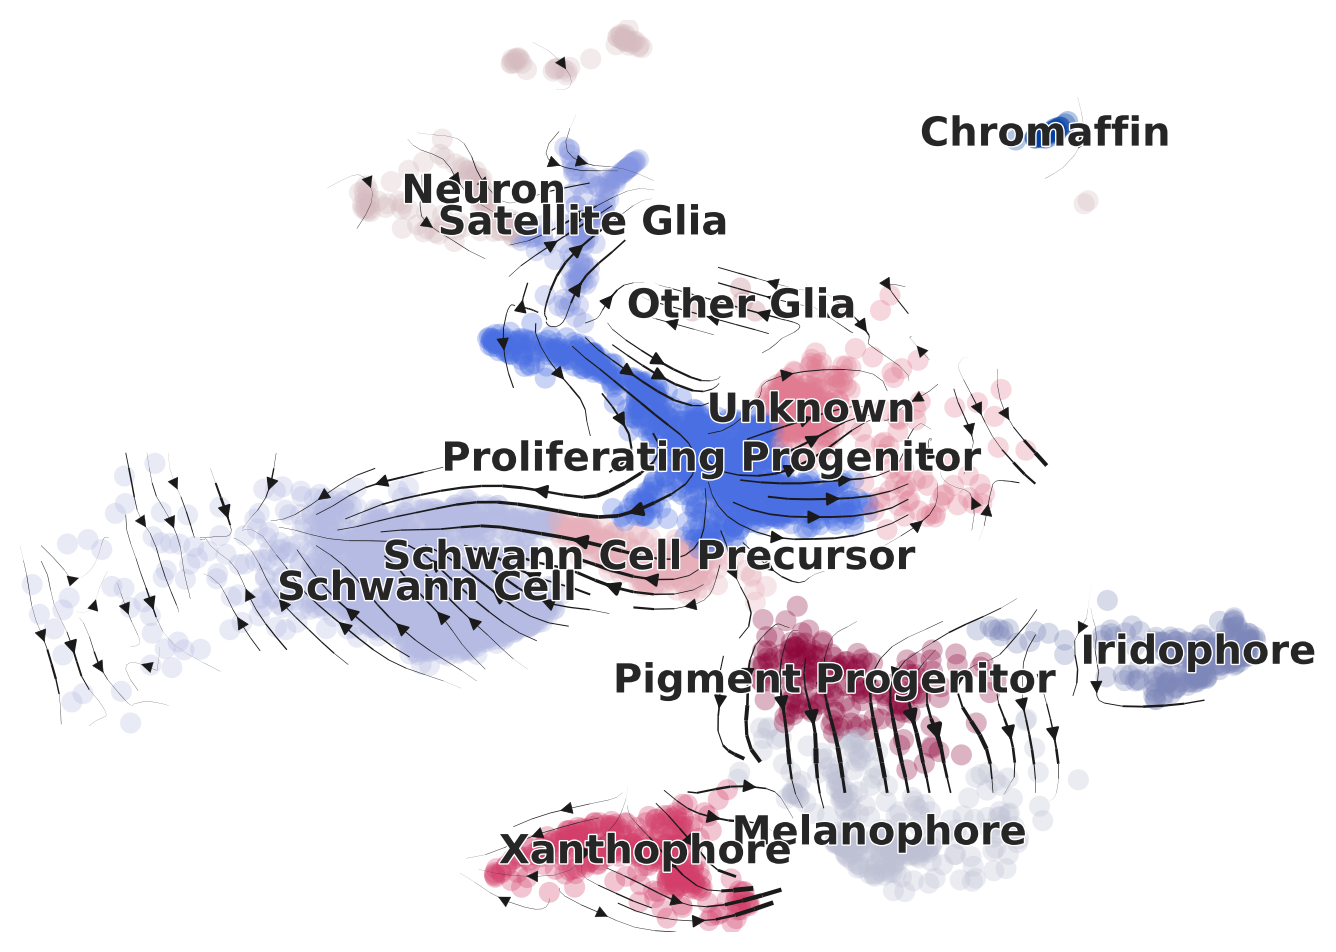

In [ ]:
import scvelo as scv
scv.tl.velocity_graph(adata, vkey='velocity',n_jobs=n_jobs)
scv.tl.velocity_embedding(adata, vkey='velocity')
scv.pl.velocity_embedding_stream(adata, vkey='velocity', color='Cell_type', figsize=(8,6), title="", save=f'{figure_path_base}/{dataset}_velocity_scv.png')

computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'full_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'full_vae_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Checkpoint2/Zebrafish/Zebrafish_velocity_full_vae.png


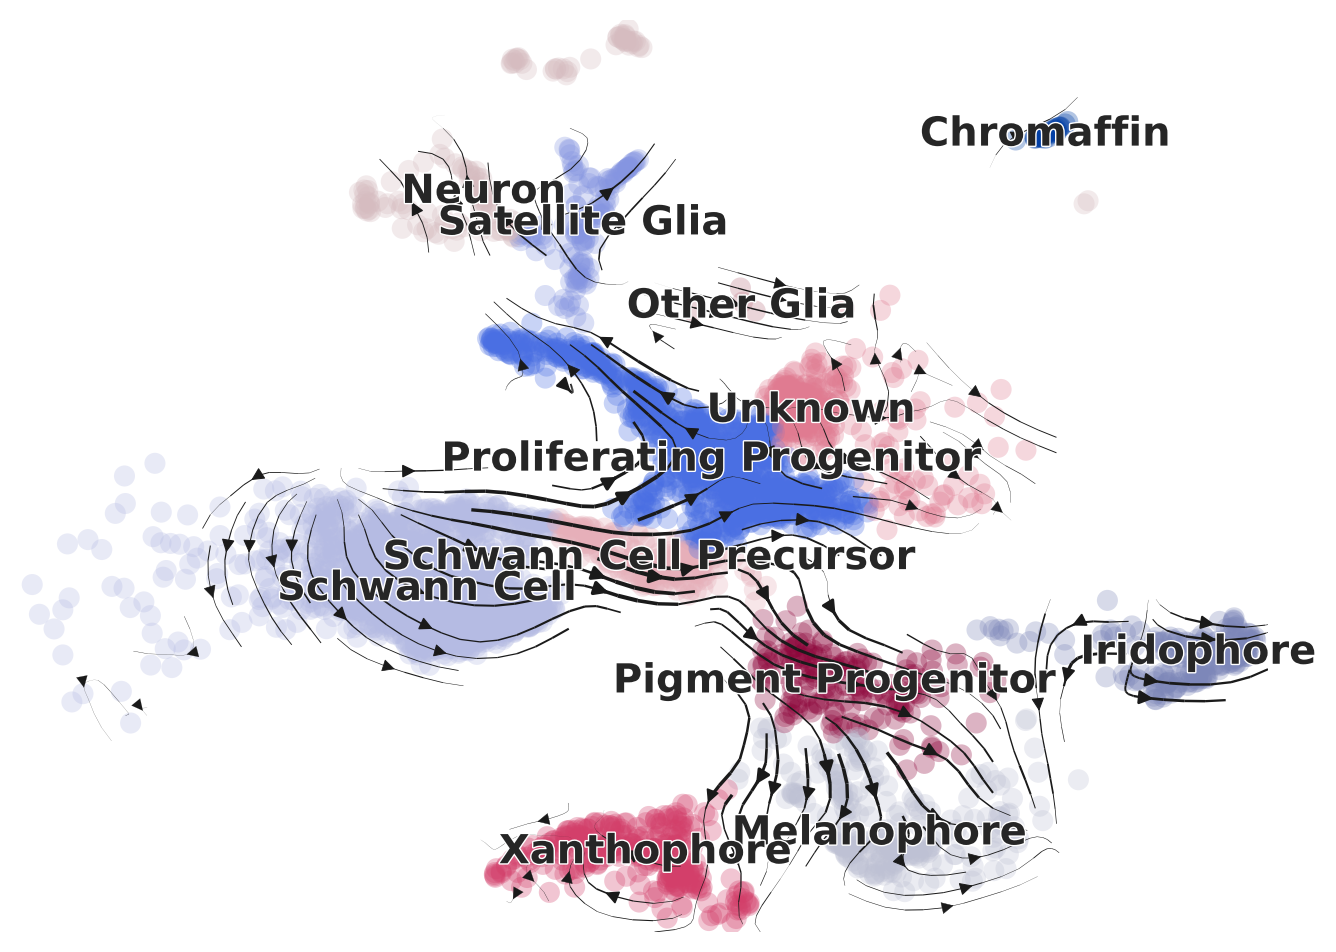

In [ ]:
key = 'full_vae'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity',n_jobs=n_jobs)
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', color='Cell_type', title="", figsize=(8,6), save=f'{figure_path_base}/{dataset}_velocity_{key}.png')

computing velocities
    finished (0:00:01) --> added 
    'full_dependent_vae_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 48/48 cores)


  0%|          | 0/4181 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'full_dependent_vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'full_dependent_vae_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Checkpoint2/Zebrafish/Zebrafish_velocity_full_dependent_vae.png


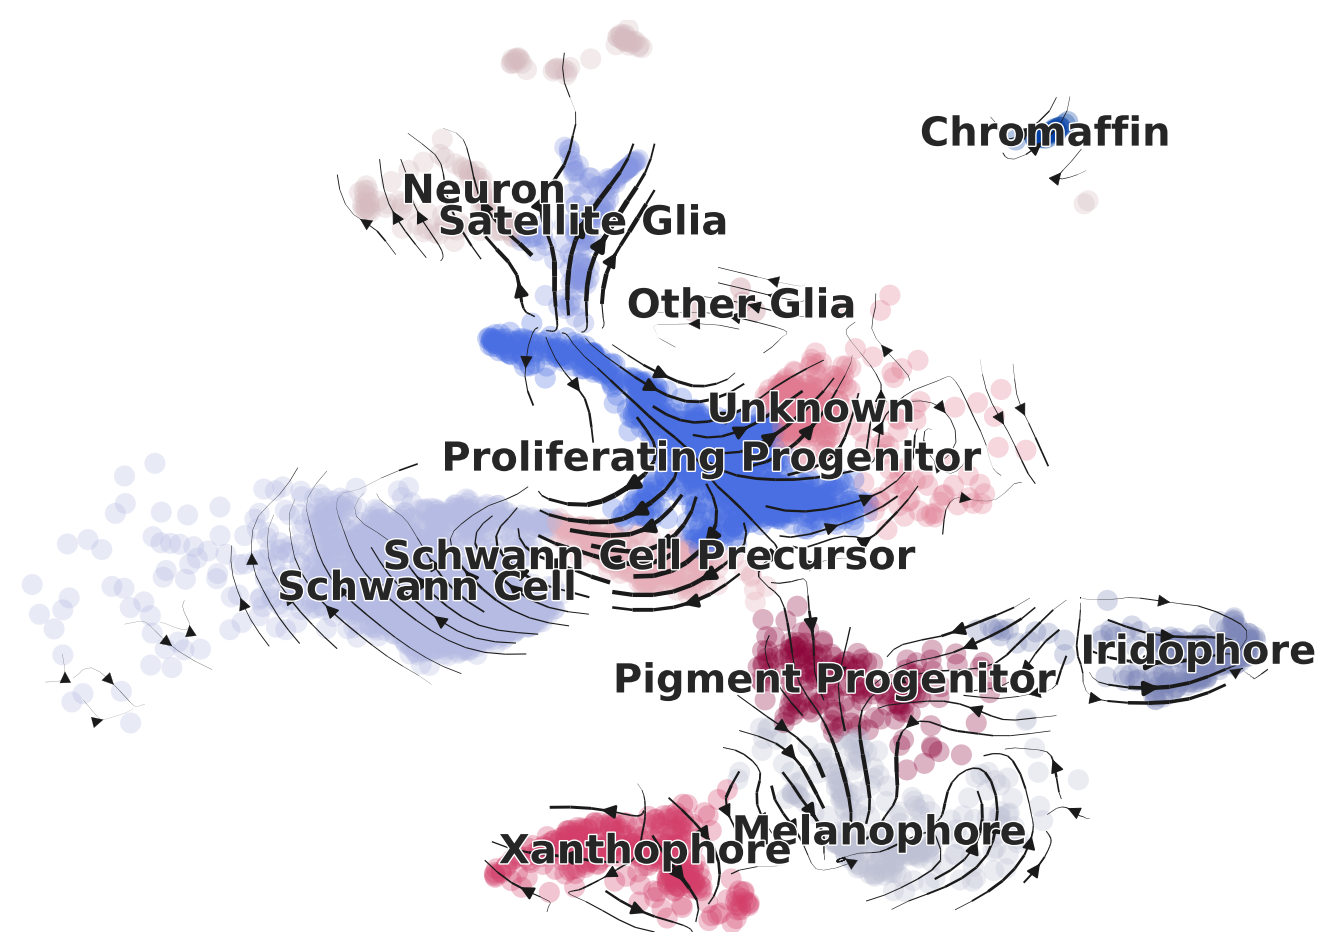

In [ ]:
key = 'full_dependent_vae'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity',n_jobs=n_jobs)
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', color='Cell_type', title="", figsize=(8,6), save=f'{figure_path_base}/{dataset}_velocity_{key}.png')

In [ ]:
adata.write_h5ad(data_path_base+"/zebrafish_out.h5ad")

# Generation

## From datapoints

In [ ]:
def sample_model(model, adata, meta_adata, n_samples=1000, sample_meta=False):

    sample_idx = np.random.permutation(adata.n_obs)[:n_samples] if n_samples is not None else range(adata.n_obs)
    spliced_samples = torch.tensor(adata.layers['Ms'][sample_idx,:], dtype=torch.float32)
    unspliced_samples = torch.tensor(adata.layers['Mu'][sample_idx,:], dtype=torch.float32)
    meta_idx = adata.obs['SEACell'][sample_idx].str.extract(r'(\d+)').astype(int).values.flatten() if n_samples is not None else sample_idx
    spliced_meta_samples = torch.tensor(meta_adata.layers['Ms'][meta_idx,:], dtype=torch.float32)
    unspliced_meta_samples = torch.tensor(meta_adata.layers['Mu'][meta_idx,:], dtype=torch.float32)
    
    n_samples = n_samples if n_samples is not None else adata.n_obs

    data = torch.concat((unspliced_samples, spliced_samples),axis=1)
    meta_data = torch.concat((unspliced_meta_samples, spliced_meta_samples),axis=1)

    data_in_scale = data.to(model.device)
    meta_data = meta_data.to(model.device) if not sample_meta else data_in_scale

    u0 = torch.tensor(model.u0, device=model.device)[sample_idx] if not sample_meta else None
    s0 = torch.tensor(model.s0, device=model.device)[sample_idx] if not sample_meta else None
    t0 = torch.tensor(model.t0, device=model.device)[sample_idx] if not sample_meta else None

    _, _, _, _, t1, zz1, uhat1, shat1, _, _, vu1, vs1, _, _, z1, _ = model.forward(data_in_scale, meta_data, u0, s0, t0)
    _, _, _, _, t2, zz2, uhat2, shat2, _, _, vu2, vs2, _, _, z2, _ = model.forward(data_in_scale, meta_data, u0, s0, t0)
    _, _, _, _, t3, zz3, uhat3, shat3, _, _, vu3, vs3, _, _, z3, _ = model.forward(data_in_scale, meta_data, u0, s0, t0)
    _, _, _, _, t4, zz4, uhat4, shat4, _, _, vu4, vs4, _, _, z4, _ = model.forward(data_in_scale, meta_data, u0, s0, t0)

    if u0 is None:
        uhat1, shat1, vu1, vs1 = uhat1[:,0,:], shat1[:,0,:], vu1[:,0,:], vs1[:,0,:]
        uhat2, shat2, vu2, vs2 = uhat2[:,0,:], shat2[:,0,:], vu2[:,0,:], vs2[:,0,:]
        uhat3, shat3, vu3, vs3 = uhat3[:,0,:], shat3[:,0,:], vu3[:,0,:], vs3[:,0,:]
        uhat4, shat4, vu4, vs4 = uhat4[:,0,:], shat4[:,0,:], vu4[:,0,:], vs4[:,0,:]
    
    sample_adata = anndata.AnnData(csr_matrix(np.zeros((4*n_samples,adata.n_vars))))
    sample_adata.var = adata.var
    sample_adata.layers['Ms'] = np.vstack((shat1.detach().cpu().numpy(),shat2.detach().cpu().numpy(),shat3.detach().cpu().numpy(),shat4.detach().cpu().numpy()))
    sample_adata.layers['Mu'] = np.vstack((uhat1.detach().cpu().numpy(),uhat2.detach().cpu().numpy(),uhat3.detach().cpu().numpy(),uhat4.detach().cpu().numpy()))
    sample_adata.layers['velocity'] = np.vstack((vs1.detach().cpu().numpy(),vs2.detach().cpu().numpy(),vs3.detach().cpu().numpy(),vs4.detach().cpu().numpy()))
    sample_adata.layers['velocity_u'] = np.vstack((vu1.detach().cpu().numpy(),vu2.detach().cpu().numpy(),vu3.detach().cpu().numpy(),vu4.detach().cpu().numpy()))
    sample_adata.obs['latent_time'] = torch.concat((t1,t2,t3,t4)).detach().cpu().numpy()
    sample_adata.obs['original_index'] = np.tile(sample_idx,4)
    sample_adata.obsm['outer_latent'] = np.vstack((z1.detach().cpu().numpy(),z2.detach().cpu().numpy(),z3.detach().cpu().numpy(),z4.detach().cpu().numpy()))
    sample_adata.obsm['inner_latent'] = np.vstack((zz1.detach().cpu().numpy(),zz2.detach().cpu().numpy(),zz3.detach().cpu().numpy(),zz4.detach().cpu().numpy()))
    
    if not sample_meta:
        sample_adata.obs['original_cell_type'] = np.tile(adata.obs['Cell_type'][sample_idx].values,4)

    return sample_adata


In [ ]:
def sample_original_model(model, adata, n_samples=1000, sample_meta=False):

    sample_idx = np.random.permutation(adata.n_obs)[:n_samples] if n_samples is not None else range(adata.n_obs)
    spliced_samples = torch.tensor(adata.layers['Ms'][sample_idx,:], dtype=torch.float32)
    unspliced_samples = torch.tensor(adata.layers['Mu'][sample_idx,:], dtype=torch.float32)
    
    n_samples = n_samples if n_samples is not None else adata.n_obs

    data = torch.concat((unspliced_samples,spliced_samples),axis=1)

    data_in_scale = data.to(model.device)
    
    u0 = torch.tensor(model.u0, device=model.device)[sample_idx] if not sample_meta else None
    s0 = torch.tensor(model.s0, device=model.device)[sample_idx] if not sample_meta else None
    t0 = torch.tensor(model.t0, device=model.device)[sample_idx] if not sample_meta else None

    _, _, _, _, t1, z1, uhat1, shat1, _, _, vu1, vs1, _, _ = model.forward(data_in_scale,u0,s0,t0)
    _, _, _, _, t2, z2, uhat2, shat2, _, _, vu2, vs2, _, _ = model.forward(data_in_scale,u0,s0,t0)
    _, _, _, _, t3, z3, uhat3, shat3, _, _, vu3, vs3, _, _ = model.forward(data_in_scale,u0,s0,t0)
    _, _, _, _, t4, z4, uhat4, shat4, _, _, vu4, vs4, _, _ = model.forward(data_in_scale,u0,s0,t0)
    
    if u0 is None:
        uhat1, shat1, vu1, vs1 = uhat1[:,0,:], shat1[:,0,:], vu1[:,0,:], vs1[:,0,:]
        uhat2, shat2, vu2, vs2 = uhat2[:,0,:], shat2[:,0,:], vu2[:,0,:], vs2[:,0,:]
        uhat3, shat3, vu3, vs3 = uhat3[:,0,:], shat3[:,0,:], vu3[:,0,:], vs3[:,0,:]
        uhat4, shat4, vu4, vs4 = uhat4[:,0,:], shat4[:,0,:], vu4[:,0,:], vs4[:,0,:]
    
    sample_adata = anndata.AnnData(csr_matrix(np.zeros((4*n_samples,adata.n_vars))))
    sample_adata.var = adata.var
    sample_adata.layers['Ms'] = np.vstack((shat1.detach().cpu().numpy(),shat2.detach().cpu().numpy(),shat3.detach().cpu().numpy(),shat4.detach().cpu().numpy()))
    sample_adata.layers['Mu'] = np.vstack((uhat1.detach().cpu().numpy(),uhat2.detach().cpu().numpy(),uhat3.detach().cpu().numpy(),uhat4.detach().cpu().numpy()))
    sample_adata.layers['velocity'] = np.vstack((vs1.detach().cpu().numpy(),vs2.detach().cpu().numpy(),vs3.detach().cpu().numpy(),vs4.detach().cpu().numpy()))
    sample_adata.layers['velocity_u'] = np.vstack((vu1.detach().cpu().numpy(),vu2.detach().cpu().numpy(),vu3.detach().cpu().numpy(),vu4.detach().cpu().numpy()))
    sample_adata.obs['latent_time'] = torch.concat((t1,t2,t3,t4)).detach().cpu().numpy()
    sample_adata.obs['original_index'] = np.tile(sample_idx,4)
    sample_adata.obsm['latent'] = np.vstack((z1.detach().cpu().numpy(),z2.detach().cpu().numpy(),z3.detach().cpu().numpy(),z4.detach().cpu().numpy()))
    
    if not sample_meta:
        sample_adata.obs['original_cell_type'] = np.tile(adata.obs['Cell_type'][sample_idx].values,4)

    return sample_adata


In [ ]:
sample_meta_adata = sample_model(full_dvae, adata, SEACell_ad, n_samples=1000)
sample_adata = sample_original_model(full_vae, adata, n_samples=1000)

In [ ]:
ump = UMAP(n_components=2)
cells_2d = ump.fit_transform(adata.layers['Ms'])

In [ ]:
sample_meta_2d = ump.transform(sample_meta_adata.layers['Ms'])
sample_2d = ump.transform(sample_adata.layers['Ms'])

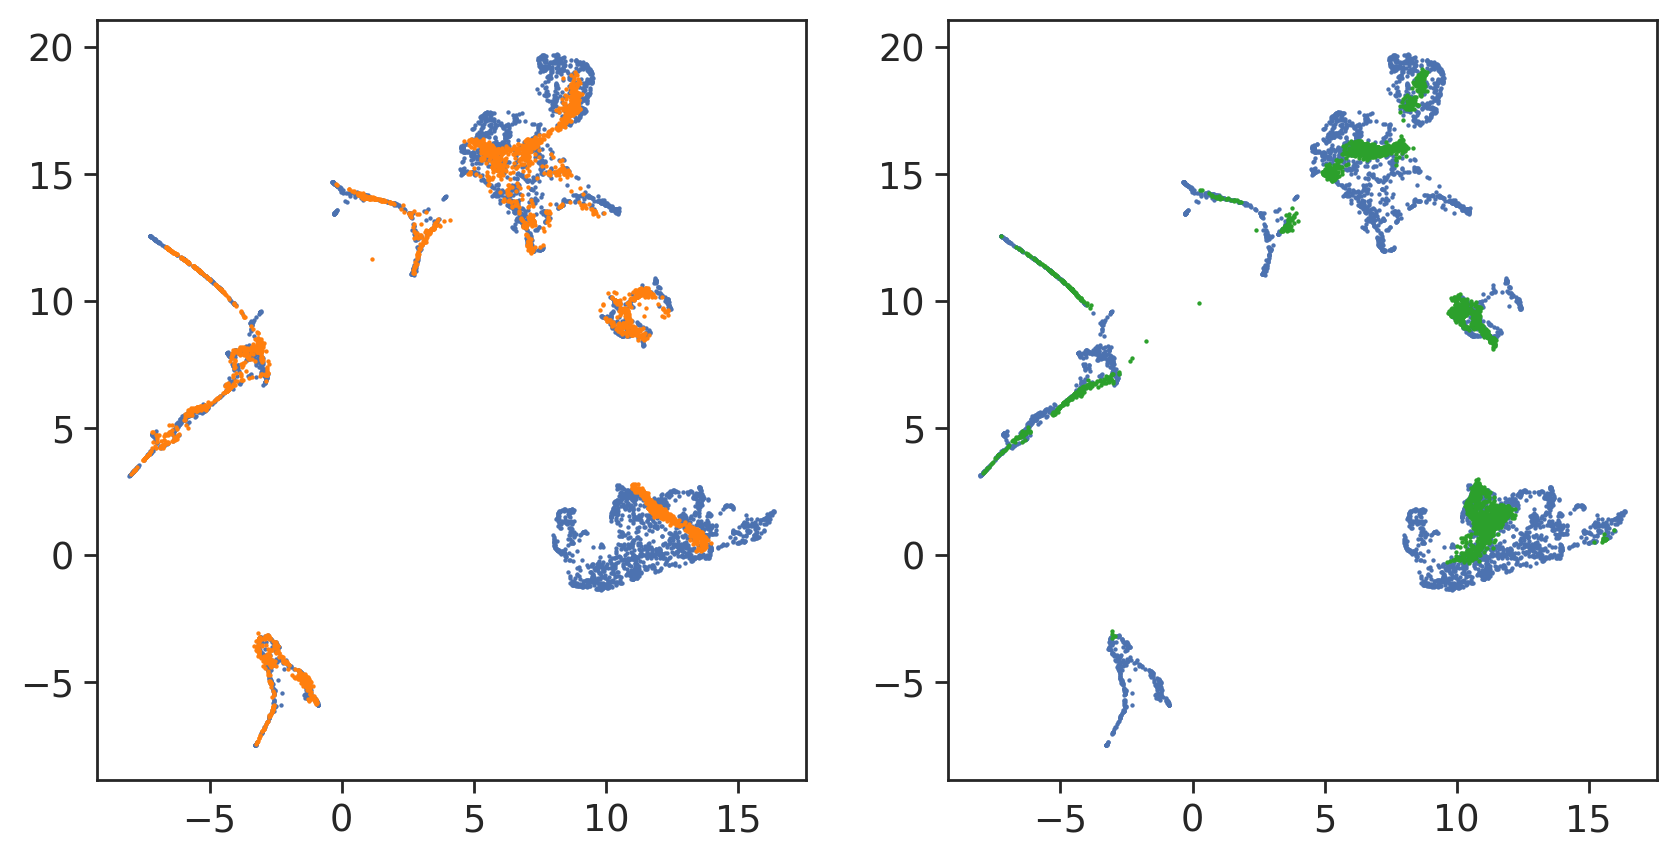

In [ ]:
fig = plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)#,projection='3d')
ax.scatter(*cells_2d.T, s=0.6)
ax.scatter(*sample_2d.T, s=0.6, c='tab:orange')

ax = plt.subplot(1,2,2)#,projection='3d')
ax.scatter(*cells_2d.T, s=0.6)
ax.scatter(*sample_meta_2d.T, s=0.6, c='tab:green')

## From Metacells

- Write down the ideas that failed (latent_variable -> time), the ones that worked(metacells), and the ones that worked but maybe were not necessary(latent varible out -> time, latent variable in).
- Add qualitative discussion of velocity fields and latent variable embeddings

In [ ]:
sample_meta_metaadata = sample_model(full_dvae, SEACell_ad, SEACell_ad, None, sample_meta=True)
sample_metaadata = sample_original_model(full_vae, SEACell_ad, None, sample_meta=True)

In [ ]:
sample_metameta_2d = ump.transform(sample_meta_metaadata.layers['Ms'])
sample_metaoriginal_2d = ump.transform(sample_metaadata.layers['Ms'])

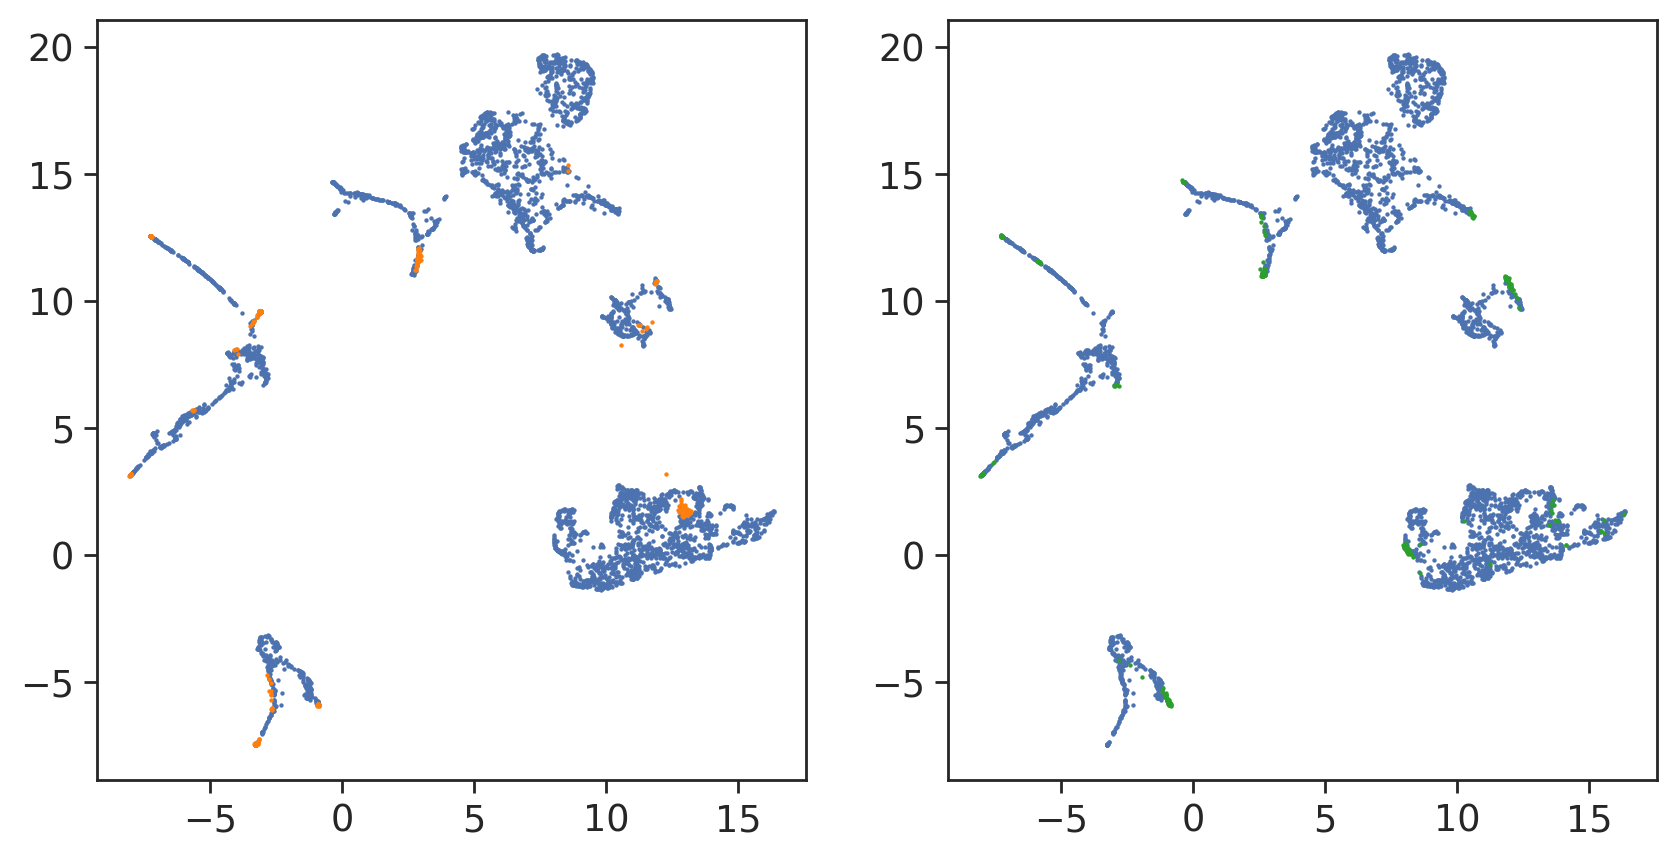

In [ ]:
fig = plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)#,projection='3d')
ax.scatter(*cells_2d.T, s=0.6)
ax.scatter(*sample_metaoriginal_2d.T, s=0.6, c='tab:orange')

ax = plt.subplot(1,2,2)#,projection='3d')
ax.scatter(*cells_2d.T, s=0.6)
ax.scatter(*sample_metameta_2d.T, s=0.6, c='tab:green')